# BLP25 Shared Task - Subtask 1A: Bangla Hate Speech Type Classification

This notebook trains a model for the BLP25 Shared Task - Subtask 1A (Bangla hate speech type classification) using XLM-RoBERTa.

## Configuration and Settings

In [1]:
# Model Selection - Choose one by commenting/uncommenting
# Option 1: DistilBERT Multilingual (faster, smaller)
#MODEL_NAME = "distilbert-base-multilingual-cased"
#MODEL_TAG = "DistilBERT_multilingual_v1"

# Option 2: XLM-RoBERTa (better performance, larger)
# MODEL_NAME = "xlm-roberta-base"
# MODEL_TAG = "XLM-R_base_v1"

# Data directory
DATA_DIR = "/kaggle/input/banglahatespeech/data"

# # Model-specific hyperparameters
# if "distilbert" in MODEL_NAME.lower():
#     # DistilBERT-specific settings (OPTIMIZED FOR SPEED)
#     MAX_LEN = 96   # Reduced from 128 for faster training
#     TRAIN_BS = 64  # Increased batch size for faster training
#     EVAL_BS = 64
#     GRAD_ACCUM = 1  # Reduced gradient accumulation
#     LR = 8e-5      # Slightly higher learning rate for faster convergence
#     EPOCHS = 3     # Reduced from 5 epochs
#     WARMUP_RATIO = 0.05  # Reduced warmup
#     WEIGHT_DECAY = 0.01
# elif "xlm-roberta" in MODEL_NAME.lower():
#     # XLM-RoBERTa-specific settings (OPTIMIZED FOR SPEED)
#     MAX_LEN = 192  # Reduced from 192
#     TRAIN_BS =16  # Increased batch size
#     EVAL_BS = 32
#     GRAD_ACCUM = 2  # Reduced accumulation
#     LR = 1e-5      # Slightly higher learning rate
#     EPOCHS = 4     # Reduced from 4 epochs
#     WARMUP_RATIO = 0.03
#     WEIGHT_DECAY = 0.01
# else:
#     # Default settings (OPTIMIZED FOR SPEED)
#     MAX_LEN = 128
#     TRAIN_BS = 32
#     EVAL_BS = 32
#     GRAD_ACCUM = 2
#     LR = 3e-5
#     EPOCHS = 2
#     WARMUP_RATIO = 0.03
#     WEIGHT_DECAY = 0.01

# Common settings
SEED = 42

# Preprocessing options
NORMALIZE_ELONGATION = True

# Labels in order
LABELS = ["Abusive", "Sexism", "Religious Hate", "Political Hate", "Profane", "None"]
label2id = {label: i for i, label in enumerate(LABELS)}
id2label = {i: label for i, label in enumerate(LABELS)}

print(f"Label mapping: {label2id}")
print(f"Number of classes: {len(LABELS)}")
print(f"Data directory: {DATA_DIR}")

Label mapping: {'Abusive': 0, 'Sexism': 1, 'Religious Hate': 2, 'Political Hate': 3, 'Profane': 4, 'None': 5}
Number of classes: 6
Data directory: /kaggle/input/banglahatespeech/data


## Package Installation

In [4]:
!pip install -q transformers datasets accelerate evaluate peft
# Additional packages for visualization if needed
!pip install -q matplotlib seaborn

## Imports and Environment Setup

In [5]:
import os
import random
import numpy as np
import pandas as pd
import torch
import re
import glob
import time
from pathlib import Path
from collections import Counter
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import zipfile
from tqdm.auto import tqdm

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback, TrainerCallback
)
from datasets import Dataset
import evaluate

# Set environment variable for MPS fallback (won't hurt on Kaggle)
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed(SEED)

# Auto-select device with multi-GPU handling
if torch.cuda.is_available():
    # Force single GPU usage to avoid multi-GPU device conflicts
    if torch.cuda.device_count() > 1:
        print(f"Multiple GPUs detected ({torch.cuda.device_count()}), using GPU 0 to avoid device conflicts")
        torch.cuda.set_device(0)
    device = torch.device('cuda:0')  # Explicitly use GPU 0
    use_fp16 = True
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    use_fp16 = False
    print("Using MPS device")
else:
    device = torch.device('cpu')
    use_fp16 = False
    print("Using CPU device")

print(f"Device: {device}")
print(f"Mixed precision (fp16): {use_fp16}")

# Set CUDA environment variables for single GPU usage
if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Force only GPU 0 to be visible
    print("Set CUDA_VISIBLE_DEVICES=0 to force single GPU usage")

Using CUDA device: Tesla P100-PCIE-16GB
Device: cuda:0
Mixed precision (fp16): True
Set CUDA_VISIBLE_DEVICES=0 to force single GPU usage


## Data Discovery and Loading

In [6]:
# Auto-discover data files
def find_data_files():
    # Primary paths (Kaggle dataset structure)
    primary_paths = {
        'train': "/kaggle/input/banglahatespeech/data/subtask_1A/blp25_hatespeech_subtask_1A_train.tsv",
        'dev': "/kaggle/input/banglahatespeech/data/subtask_1A/blp25_hatespeech_subtask_1A_dev.tsv",
        'test': "/kaggle/input/banglahatespeech/data/subtask_1A/blp25_hatespeech_subtask_1A_dev_test.tsv"
    }
    

    
    # Try primary paths first
    train_path = primary_paths['train'] if os.path.exists(primary_paths['train']) else None
    dev_path = primary_paths['dev'] if os.path.exists(primary_paths['dev']) else None
    test_path = primary_paths['test'] if os.path.exists(primary_paths['test']) else None
    
   
    
    # Final fallback to DATA_DIR if still not found
    if not train_path:
        train_path = os.path.join(DATA_DIR, "subtask_1A", "blp25_hatespeech_subtask_1A_train.tsv")
    if not dev_path:
        dev_path = os.path.join(DATA_DIR, "subtask_1A", "blp25_hatespeech_subtask_1A_dev.tsv") 
    if not test_path:
        test_path = os.path.join(DATA_DIR, "subtask_1A", "blp25_hatespeech_subtask_1A_dev_test.tsv")
        
    return train_path, dev_path, test_path

train_file, dev_file, test_file = find_data_files()

print("Discovered data paths:")
print(f"Train: {train_file}")
print(f"Dev: {dev_file}")
print(f"Test: {test_file}")

# Check if files exist
for name, path in [("Train", train_file), ("Dev", dev_file), ("Test", test_file)]:
    if os.path.exists(path):
        print(f"✓ {name} file exists")
    else:
        print(f"✗ {name} file not found at {path}")
        if name in ["Train", "Dev"]:
            print(f"  Please upload data to: /kaggle/input/banglahatespeech/")

# Load data with proper handling of "None" labels
def load_tsv(file_path):
    if os.path.exists(file_path):
        # Load with keep_default_na=False to prevent "None" from being converted to NaN
        df = pd.read_csv(file_path, sep='\t', keep_default_na=False, na_values=[''])
        return df
    else:
        return None

train_df = load_tsv(train_file)
dev_df = load_tsv(dev_file) 
test_df = load_tsv(test_file)

if train_df is not None:
    print(f"\nTrain dataset shape: {train_df.shape}")
    print(f"Train columns: {list(train_df.columns)}")
    print(f"Train label distribution:\n{train_df['label'].value_counts()}")
    
    # Check for any actual missing values
    actual_missing = train_df['label'].isna().sum()
    if actual_missing > 0:
        print(f"Actual missing labels: {actual_missing}")
    
if dev_df is not None:
    print(f"\nDev dataset shape: {dev_df.shape}")
    print(f"Dev columns: {list(dev_df.columns)}")
    print(f"Dev label distribution:\n{dev_df['label'].value_counts()}")
    
    # Check for any actual missing values
    actual_missing = dev_df['label'].isna().sum()
    if actual_missing > 0:
        print(f"Actual missing labels in dev: {actual_missing}")
    
if test_df is not None:
    print(f"\nTest dataset shape: {test_df.shape}")
    print(f"Test columns: {list(test_df.columns)}")

Discovered data paths:
Train: /kaggle/input/banglahatespeech/data/subtask_1A/blp25_hatespeech_subtask_1A_train.tsv
Dev: /kaggle/input/banglahatespeech/data/subtask_1A/blp25_hatespeech_subtask_1A_dev.tsv
Test: /kaggle/input/banglahatespeech/data/subtask_1A/blp25_hatespeech_subtask_1A_dev_test.tsv
✓ Train file exists
✓ Dev file exists
✓ Test file exists

Train dataset shape: (35522, 3)
Train columns: ['id', 'text', 'label']
Train label distribution:
label
None              19954
Abusive            8212
Political Hate     4227
Profane            2331
Religious Hate      676
Sexism              122
Name: count, dtype: int64

Dev dataset shape: (2512, 3)
Dev columns: ['id', 'text', 'label']
Dev label distribution:
label
None              1451
Abusive            564
Political Hate     291
Profane            157
Religious Hate      38
Sexism              11
Name: count, dtype: int64

Test dataset shape: (2512, 2)
Test columns: ['id', 'text']


## Exploratory Data Analysis (EDA)

Let's explore the dataset to understand the characteristics of our Bangla hate speech data.

In [7]:
# Basic Dataset Statistics
if train_df is not None:
    print("="*60)
    print("TRAINING DATASET OVERVIEW")
    print("="*60)
    print(f"Total samples: {len(train_df):,}")
    print(f"Columns: {list(train_df.columns)}")
    print(f"Memory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Check for missing values
    print("\nMissing values:")
    missing_values = train_df.isnull().sum()
    for col, missing in missing_values.items():
        if missing > 0:
            print(f"  {col}: {missing} ({missing/len(train_df)*100:.2f}%)")
        else:
            print(f"  {col}: 0")
    
    # Basic text statistics
    print("\nText Statistics:")
    train_df['text_length'] = train_df['text'].astype(str).str.len()
    train_df['word_count'] = train_df['text'].astype(str).str.split().str.len()
    
    print(f"  Average text length: {train_df['text_length'].mean():.1f} characters")
    print(f"  Median text length: {train_df['text_length'].median():.1f} characters")
    print(f"  Min text length: {train_df['text_length'].min()}")
    print(f"  Max text length: {train_df['text_length'].max()}")
    print(f"  Average word count: {train_df['word_count'].mean():.1f} words")
    print(f"  Median word count: {train_df['word_count'].median():.1f} words")
    
else:
    print("No training data available for EDA")

TRAINING DATASET OVERVIEW
Total samples: 35,522
Columns: ['id', 'text', 'label']
Memory usage: 10.49 MB

Missing values:
  id: 0
  text: 0
  label: 0

Text Statistics:
  Average text length: 78.2 characters
  Median text length: 51.0 characters
  Min text length: 7
  Max text length: 3710
  Average word count: 13.8 words
  Median word count: 9.0 words


In [8]:
# Label Distribution Analysis
if train_df is not None:
    print("\n" + "="*60)
    print("LABEL DISTRIBUTION ANALYSIS")
    print("="*60)
    
    # Count and percentage of each label
    label_counts = train_df['label'].value_counts()
    label_percentages = train_df['label'].value_counts(normalize=True) * 100
    
    print("Label distribution:")
    for label in LABELS:
        count = label_counts.get(label, 0)
        percentage = label_percentages.get(label, 0)
        print(f"  {label:<15}: {count:>6} samples ({percentage:>5.1f}%)")
    
    # Calculate class imbalance ratio
    max_count = label_counts.max()
    min_count = label_counts.min()
    imbalance_ratio = max_count / min_count
    print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
    print(f"Most frequent class: {label_counts.index[0]} ({label_counts.iloc[0]} samples)")
    print(f"Least frequent class: {label_counts.index[-1]} ({label_counts.iloc[-1]} samples)")
    
    # Check if all expected labels are present
    missing_labels = set(LABELS) - set(train_df['label'].unique())
    if missing_labels:
        print(f"\nMissing labels in training data: {missing_labels}")
    else:
        print(f"\n✓ All {len(LABELS)} expected labels present in training data")

if dev_df is not None:
    print("\n" + "-"*40)
    print("DEVELOPMENT SET COMPARISON")
    print("-"*40)
    
    dev_label_counts = dev_df['label'].value_counts()
    dev_label_percentages = dev_df['label'].value_counts(normalize=True) * 100
    
    print("Dev set label distribution:")
    for label in LABELS:
        count = dev_label_counts.get(label, 0)
        percentage = dev_label_percentages.get(label, 0)
        train_pct = label_percentages.get(label, 0)
        diff = percentage - train_pct
        print(f"  {label:<15}: {count:>4} samples ({percentage:>5.1f}%) [diff: {diff:>+5.1f}%]")
    
else:
    print("\nNo development data available for comparison")


LABEL DISTRIBUTION ANALYSIS
Label distribution:
  Abusive        :   8212 samples ( 23.1%)
  Sexism         :    122 samples (  0.3%)
  Religious Hate :    676 samples (  1.9%)
  Political Hate :   4227 samples ( 11.9%)
  Profane        :   2331 samples (  6.6%)
  None           :  19954 samples ( 56.2%)

Class imbalance ratio: 163.56:1
Most frequent class: None (19954 samples)
Least frequent class: Sexism (122 samples)

✓ All 6 expected labels present in training data

----------------------------------------
DEVELOPMENT SET COMPARISON
----------------------------------------
Dev set label distribution:
  Abusive        :  564 samples ( 22.5%) [diff:  -0.7%]
  Sexism         :   11 samples (  0.4%) [diff:  +0.1%]
  Religious Hate :   38 samples (  1.5%) [diff:  -0.4%]
  Political Hate :  291 samples ( 11.6%) [diff:  -0.3%]
  Profane        :  157 samples (  6.2%) [diff:  -0.3%]
  None           : 1451 samples ( 57.8%) [diff:  +1.6%]


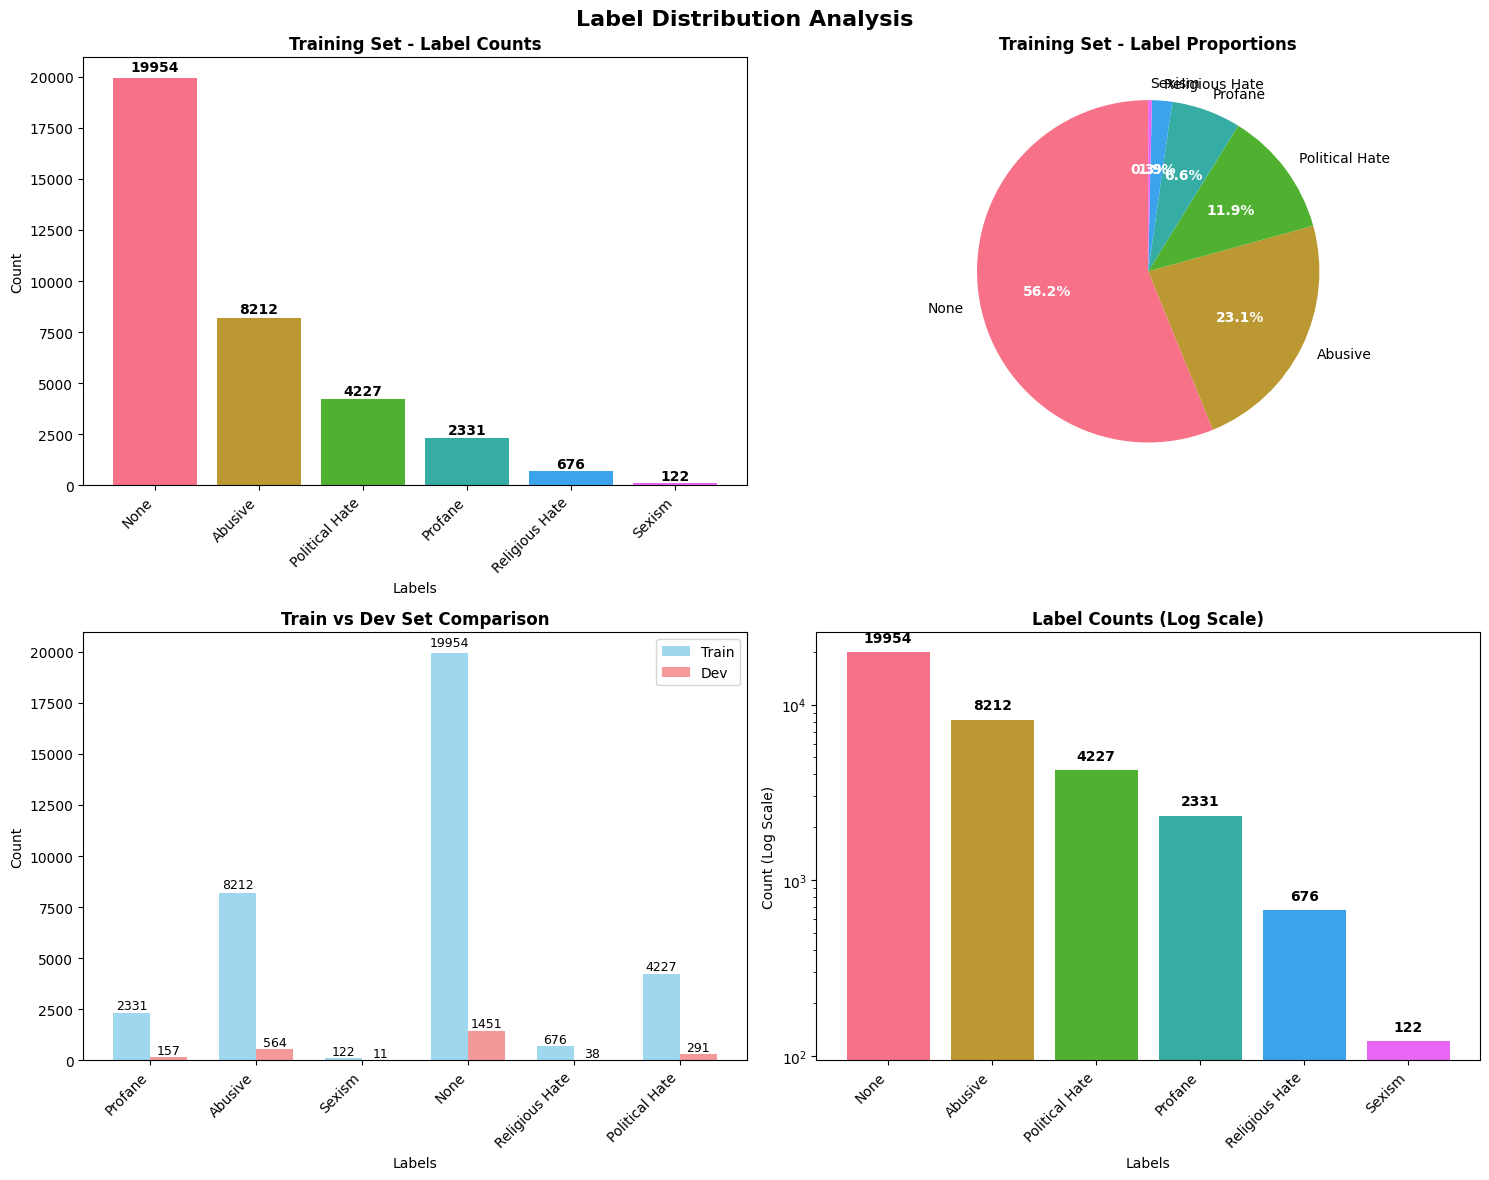


LABEL DISTRIBUTION STATISTICS
Most frequent label: None (19,954 samples)
Least frequent label: Sexism (122 samples)
Imbalance ratio: 163.56:1
Standard deviation: 7470.88
Coefficient of variation: 1.26


In [9]:
# Visualize Label Distribution
import matplotlib.pyplot as plt
import seaborn as sns

if train_df is not None:
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Label Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Bar plot of label counts
    ax1 = axes[0, 0]
    label_counts = train_df['label'].value_counts()
    bars = ax1.bar(range(len(label_counts)), label_counts.values, 
                   color=sns.color_palette("husl", len(label_counts)))
    ax1.set_title('Training Set - Label Counts', fontweight='bold')
    ax1.set_xlabel('Labels')
    ax1.set_ylabel('Count')
    ax1.set_xticks(range(len(label_counts)))
    ax1.set_xticklabels(label_counts.index, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Pie chart of label proportions
    ax2 = axes[0, 1]
    colors = sns.color_palette("husl", len(label_counts))
    wedges, texts, autotexts = ax2.pie(label_counts.values, labels=label_counts.index, 
                                      autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Training Set - Label Proportions', fontweight='bold')
    
    # Make percentage text bold and readable
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    # 3. Comparison with dev set (if available)
    ax3 = axes[1, 0]
    if dev_df is not None:
        dev_label_counts = dev_df['label'].value_counts()
        
        # Align labels for comparison
        all_labels = list(set(label_counts.index) | set(dev_label_counts.index))
        train_counts = [label_counts.get(label, 0) for label in all_labels]
        dev_counts = [dev_label_counts.get(label, 0) for label in all_labels]
        
        x = range(len(all_labels))
        width = 0.35
        
        bars1 = ax3.bar([i - width/2 for i in x], train_counts, width, 
                       label='Train', alpha=0.8, color='skyblue')
        bars2 = ax3.bar([i + width/2 for i in x], dev_counts, width, 
                       label='Dev', alpha=0.8, color='lightcoral')
        
        ax3.set_title('Train vs Dev Set Comparison', fontweight='bold')
        ax3.set_xlabel('Labels')
        ax3.set_ylabel('Count')
        ax3.set_xticks(x)
        ax3.set_xticklabels(all_labels, rotation=45, ha='right')
        ax3.legend()
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                            f'{int(height)}', ha='center', va='bottom', fontsize=9)
    else:
        ax3.text(0.5, 0.5, 'No development data available', 
                ha='center', va='center', transform=ax3.transAxes, 
                fontsize=14, style='italic')
        ax3.set_title('Train vs Dev Set Comparison', fontweight='bold')
    
    # 4. Log scale bar plot (useful for imbalanced data)
    ax4 = axes[1, 1]
    bars = ax4.bar(range(len(label_counts)), label_counts.values, 
                   color=sns.color_palette("husl", len(label_counts)))
    ax4.set_yscale('log')
    ax4.set_title('Label Counts (Log Scale)', fontweight='bold')
    ax4.set_xlabel('Labels')
    ax4.set_ylabel('Count (Log Scale)')
    ax4.set_xticks(range(len(label_counts)))
    ax4.set_xticklabels(label_counts.index, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.1,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics
    print("\n" + "="*50)
    print("LABEL DISTRIBUTION STATISTICS")
    print("="*50)
    print(f"Most frequent label: {label_counts.index[0]} ({label_counts.iloc[0]:,} samples)")
    print(f"Least frequent label: {label_counts.index[-1]} ({label_counts.iloc[-1]:,} samples)")
    print(f"Imbalance ratio: {label_counts.iloc[0]/label_counts.iloc[-1]:.2f}:1")
    print(f"Standard deviation: {label_counts.std():.2f}")
    print(f"Coefficient of variation: {label_counts.std()/label_counts.mean():.2f}")

else:
    print("No training data available for visualization")

In [10]:
# Text Length Analysis by Label
if train_df is not None:
    print("\n" + "="*60)
    print("TEXT LENGTH ANALYSIS BY LABEL")
    print("="*60)
    
    # Calculate text length statistics for each label
    print(f"{'Label':<15} {'Count':<6} {'Avg Len':<8} {'Med Len':<8} {'Min':<5} {'Max':<6} {'Avg Words':<10}")
    print("-" * 70)
    
    for label in LABELS:
        if label in train_df['label'].values:
            label_data = train_df[train_df['label'] == label]
            avg_len = label_data['text_length'].mean()
            med_len = label_data['text_length'].median()
            min_len = label_data['text_length'].min()
            max_len = label_data['text_length'].max()
            avg_words = label_data['word_count'].mean()
            count = len(label_data)
            
            print(f"{label:<15} {count:<6} {avg_len:<8.1f} {med_len:<8.1f} {min_len:<5} {max_len:<6} {avg_words:<10.1f}")
        else:
            print(f"{label:<15} {'0':<6} {'N/A':<8} {'N/A':<8} {'N/A':<5} {'N/A':<6} {'N/A':<10}")
    
    # Find outliers (very short or very long texts)
    print("\n" + "-"*40)
    print("TEXT LENGTH OUTLIERS")
    print("-"*40)
    
    # Very short texts (< 10 characters)
    short_texts = train_df[train_df['text_length'] < 10]
    if len(short_texts) > 0:
        print(f"\nVery short texts (< 10 chars): {len(short_texts)} samples")
        print("Examples:")
        for i, row in short_texts.head(3).iterrows():
            print(f"  Label: {row['label']}, Length: {row['text_length']}, Text: '{row['text']}'")
    
    # Very long texts (> 500 characters) 
    long_texts = train_df[train_df['text_length'] > 500]
    if len(long_texts) > 0:
        print(f"\nVery long texts (> 500 chars): {len(long_texts)} samples")
        print("Examples:")
        for i, row in long_texts.head(3).iterrows():
            text_preview = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
            print(f"  Label: {row['label']}, Length: {row['text_length']}, Text: '{text_preview}'")


TEXT LENGTH ANALYSIS BY LABEL
Label           Count  Avg Len  Med Len  Min   Max    Avg Words 
----------------------------------------------------------------------
Abusive         8212   78.2     54.0     9     3707   14.0      
Sexism          122    93.8     62.0     14    746    16.3      
Religious Hate  676    97.3     72.0     15    1068   16.5      
Political Hate  4227   111.5    76.0     11    3663   19.2      
Profane         2331   77.4     51.0     8     3344   13.7      
None            19954  70.5     45.0     7     3710   12.4      

----------------------------------------
TEXT LENGTH OUTLIERS
----------------------------------------

Very short texts (< 10 chars): 23 samples
Examples:
  Label: None, Length: 9, Text: '৪ দিন ৪২৯'
  Label: None, Length: 8, Text: 'চা বা হে'
  Label: None, Length: 7, Text: 'কো থা য়'

Very long texts (> 500 chars): 258 samples
Examples:
  Label: None, Length: 3696, Text: 'আমরা হলাম শিক্ষিত রুপে অশিক্ষিত অসভ্য নোংরা বিশৃঙ্খলা অনিয়মদুর্নীতি

In [11]:
# Bangla Text Pattern Analysis
if train_df is not None:
    print("\n" + "="*60)
    print("BANGLA TEXT PATTERN ANALYSIS")
    print("="*60)
    
    # Analyze character patterns
    all_text = ' '.join(train_df['text'].astype(str))
    
    # Count Bangla vs non-Bangla characters
    bangla_chars = re.findall(r'[\u0980-\u09FF]', all_text)
    english_chars = re.findall(r'[a-zA-Z]', all_text)
    digits = re.findall(r'[0-9]', all_text)
    punctuation = re.findall(r'[।!?.,;:()\-"\'@#$%^&*+=<>/\\|`~_\[\]{}]', all_text)
    
    total_chars = len(all_text.replace(' ', ''))
    
    print(f"Character distribution in dataset:")
    print(f"  Bangla characters: {len(bangla_chars):,} ({len(bangla_chars)/total_chars*100:.1f}%)")
    print(f"  English characters: {len(english_chars):,} ({len(english_chars)/total_chars*100:.1f}%)")
    print(f"  Digits: {len(digits):,} ({len(digits)/total_chars*100:.1f}%)")
    print(f"  Punctuation: {len(punctuation):,} ({len(punctuation)/total_chars*100:.1f}%)")
    print(f"  Total characters (excluding spaces): {total_chars:,}")
    
    # Check for mixed language texts
    mixed_lang_count = 0
    for text in train_df['text'].astype(str):
        has_bangla = bool(re.search(r'[\u0980-\u09FF]', text))
        has_english = bool(re.search(r'[a-zA-Z]', text))
        if has_bangla and has_english:
            mixed_lang_count += 1
    
    print(f"\nMixed language texts: {mixed_lang_count:,} ({mixed_lang_count/len(train_df)*100:.1f}%)")
    
    # Common patterns
    print(f"\nCommon patterns:")
    
    # URLs
    url_pattern = r'http[s]?://[^\s]+'
    url_count = sum(1 for text in train_df['text'].astype(str) if re.search(url_pattern, text))
    print(f"  Texts with URLs: {url_count:,} ({url_count/len(train_df)*100:.1f}%)")
    
    # Mentions (@username)
    mention_pattern = r'@\w+'
    mention_count = sum(1 for text in train_df['text'].astype(str) if re.search(mention_pattern, text))
    print(f"  Texts with mentions: {mention_count:,} ({mention_count/len(train_df)*100:.1f}%)")
    
    # Hashtags
    hashtag_pattern = r'#\w+'
    hashtag_count = sum(1 for text in train_df['text'].astype(str) if re.search(hashtag_pattern, text))
    print(f"  Texts with hashtags: {hashtag_count:,} ({hashtag_count/len(train_df)*100:.1f}%)")
    
    # Phone numbers (Bangladeshi pattern)
    phone_pattern = r'(\+?88)?[-.\s]?01[3-9]\d{8}'
    phone_count = sum(1 for text in train_df['text'].astype(str) if re.search(phone_pattern, text))
    print(f"  Texts with phone numbers: {phone_count:,} ({phone_count/len(train_df)*100:.1f}%)")
    
    # Repeated characters (potential elongation)
    elongation_pattern = r'(.)\1{2,}'
    elongation_count = sum(1 for text in train_df['text'].astype(str) if re.search(elongation_pattern, text))
    print(f"  Texts with elongation: {elongation_count:,} ({elongation_count/len(train_df)*100:.1f}%)")
    
    # Excessive punctuation
    excessive_punct_pattern = r'([।!?.,;:]){3,}'
    excessive_punct_count = sum(1 for text in train_df['text'].astype(str) if re.search(excessive_punct_pattern, text))
    print(f"  Texts with excessive punctuation: {excessive_punct_count:,} ({excessive_punct_count/len(train_df)*100:.1f}%)")


BANGLA TEXT PATTERN ANALYSIS
Character distribution in dataset:
  Bangla characters: 2,324,863 (100.0%)
  English characters: 0 (0.0%)
  Digits: 0 (0.0%)
  Punctuation: 0 (0.0%)
  Total characters (excluding spaces): 2,324,863

Mixed language texts: 0 (0.0%)

Common patterns:
  Texts with URLs: 0 (0.0%)
  Texts with mentions: 0 (0.0%)
  Texts with hashtags: 0 (0.0%)
  Texts with phone numbers: 0 (0.0%)
  Texts with elongation: 151 (0.4%)
  Texts with excessive punctuation: 0 (0.0%)


In [12]:
# Sample Text Examples by Label
if train_df is not None:
    print("\n" + "="*60)
    print("SAMPLE TEXTS BY LABEL")
    print("="*60)
    
    for label in LABELS:
        if label in train_df['label'].values:
            label_samples = train_df[train_df['label'] == label].head(3)
            print(f"\n{label.upper()} Examples:")
            print("-" * 40)
            
            for i, (idx, row) in enumerate(label_samples.iterrows(), 1):
                text_preview = row['text'][:150] + "..." if len(row['text']) > 150 else row['text']
                print(f"{i}. (Length: {len(row['text'])} chars)")
                print(f"   Text: {text_preview}")
                print()
        else:
            print(f"\n{label.upper()}: No samples found")
            print("-" * 40)
    
    print("\n" + "="*60)
    print("DATA QUALITY INSIGHTS")
    print("="*60)
    
    # Check for potential data quality issues
    empty_texts = train_df[train_df['text'].astype(str).str.strip() == ''].shape[0]
    very_short = train_df[train_df['text_length'] < 5].shape[0]
    very_long = train_df[train_df['text_length'] > 1000].shape[0]
    
    print(f"Potential data quality issues:")
    print(f"  Empty/whitespace-only texts: {empty_texts}")
    print(f"  Very short texts (< 5 chars): {very_short}")
    print(f"  Very long texts (> 1000 chars): {very_long}")
    
    # Unique text ratio
    unique_texts = train_df['text'].nunique()
    duplicate_ratio = 1 - (unique_texts / len(train_df))
    print(f"  Duplicate texts: {len(train_df) - unique_texts} ({duplicate_ratio*100:.1f}%)")
    
    print(f"\nRecommendations for preprocessing:")
    if empty_texts > 0:
        print(f"  - Handle {empty_texts} empty texts")
    if elongation_count > len(train_df) * 0.1:
        print(f"  - Character elongation normalization recommended ({elongation_count} affected texts)")
    if url_count > 0:
        print(f"  - URL removal/replacement recommended ({url_count} texts with URLs)")
    if duplicate_ratio > 0.05:
        print(f"  - Consider handling duplicates ({duplicate_ratio*100:.1f}% duplication rate)")
    
    print(f"\nDataset appears suitable for training with appropriate preprocessing.")


SAMPLE TEXTS BY LABEL

ABUSIVE Examples:
----------------------------------------
1. (Length: 41 chars)
   Text: অতিরিক্ত এ নিজেকে বাদুর বানাইয়া ফেলছেন রে

2. (Length: 67 chars)
   Text: এটার বিচার কে করবেযে বিচার করবে সেই তো হলো এই সমস্ত চোরদের গড ফাদার

3. (Length: 87 chars)
   Text: ইরান পারমাণবিক বোমা বানাবে বানাবে বলতে বলতে বিয়া করার বয়স হই গেছে বোমা আর বানানো হলো না


SEXISM Examples:
----------------------------------------
1. (Length: 209 chars)
   Text: অযোগ্য মহিলাদের হাতে ক্ষমতা দিয়ে দেশকে রষাতলে ফেলার আগ্রহ দেশবাসীর নাই খোদ আমেরিকায় ও এখনও কোন নারী প্রেসিডেন্ট হয়নি মমতাজ এতদিন ভিন্নদলের স্বতন্ত্র প...

2. (Length: 53 chars)
   Text: বউটা কলগাড এত বড় এক ফুটবলারের বউ আর পোষাক পরচে এত ছোট

3. (Length: 51 chars)
   Text: আমাকে দিবেন প্লিজ আমার দুই ছেলে হয়েছিল মরে গিয়েছে


RELIGIOUS HATE Examples:
----------------------------------------
1. (Length: 135 chars)
   Text: ভারত নিয়ে এত কথা হয় ভারতে একটা মসজিদ ভাঙ্গা হয়েছে আর আফগানিস্তান পাকিস্তানে প্রতিদিন হাজার হাজার মসজিদে ব

## Text Preprocessing

### Preprocessing Imports and Configuration

In [13]:
import re
import unicodedata
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# Emoji to Bangla text mapping (expandable dictionary)
EMOJI_MAPPING = {
    # Happy/Positive emotions
    '🙂': 'হাসি',
    '😊': 'খুশি',
    '😀': 'আনন্দ',
    '😄': 'হাসি',
    '😃': 'আনন্দ',
    '😁': 'হাসি',
    '🤣': 'হাসি',
    '😂': 'হাসি',
    '😆': 'হাসি',
    '😍': 'ভালোবাসা',
    '🥰': 'ভালোবাসা',
    '😘': 'চুমু',
    '😗': 'চুমু',
    '😙': 'চুমু',
    '😚': 'চুমু',
    '😎': 'স্টাইলিশ',
    '🤗': 'আলিঙ্গন',
    
    # Sad/Negative emotions
    '😢': 'কান্না',
    '😭': 'কান্না',
    '😞': 'দুঃখ',
    '😔': 'দুঃখ',
    '😟': 'চিন্তা',
    '😕': 'দুঃখ',
    '🙁': 'দুঃখ',
    '😒': 'বিরক্তি',
    '😓': 'হতাশা',
    '😖': 'কষ্ট',
    '😣': 'কষ্ট',
    
    # Angry/Aggressive emotions
    '😠': 'রাগ',
    '😡': 'রাগ',
    '🤬': 'রাগ',
    '😤': 'রাগ',
    '👿': 'রাগ',
    '💀': 'মৃত্যু',
    '☠️': 'মৃত্যু',
    
    # Surprised/Shocked
    '😱': 'চমক',
    '😨': 'ভয়',
    '😰': 'ভয়',
    '😯': 'চমক',
    '😲': 'চমক',
    '🤯': 'চমক',
    
    # Other common emojis
    '👍': 'ভালো',
    '👎': 'খারাপ',
    '👏': 'তালি',
    '🔥': 'আগুন',
    '💯': 'শতভাগ',
    '❤️': 'ভালোবাসা',
    '💔': 'ভাঙা_হৃদয়',
    '🖤': 'কালো_হৃদয়',
    '💩': 'নোংরা',
    '🐍': 'সাপ',
    '🤡': 'জোকার',
    
    # Symbols
    '✅': 'সঠিক',
    '❌': 'ভুল',
    '⚠️': 'সাবধান',
    '🚫': 'নিষিদ্ধ',
    '🔞': 'প্রাপ্তবয়স্ক',
}

print(f"✅ Preprocessing imports loaded")
print(f"✅ Emoji mapping configured with {len(EMOJI_MAPPING)} emojis")

✅ Preprocessing imports loaded
✅ Emoji mapping configured with 57 emojis


### Unicode and Character Normalization Functions

These functions handle Unicode normalization, Bangla digit conversion, and control character removal.

In [14]:
def normalize_unicode_text(text):
    """Normalize Unicode characters using NFKC normalization"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    # NFKC normalization - handles compatibility characters and canonical decomposition
    text = unicodedata.normalize('NFKC', text)
    return text

def normalize_bangla_digits(text):
    """Convert Bangla digits to English digits for consistency"""
    if pd.isna(text):
        return ""
    
    # Bangla digits to English digits mapping
    bangla_digits = '০১২৩৪৫৬৭৮৯'
    english_digits = '0123456789'
    
    for bangla, english in zip(bangla_digits, english_digits):
        text = text.replace(bangla, english)
    
    return text

def remove_control_characters(text):
    """Remove control characters but preserve newlines and tabs if needed"""
    if pd.isna(text):
        return ""
    
    # Remove control characters except newline, tab, and carriage return
    # Keep \n, \r, \t as they might be meaningful in text
    text = ''.join(char for char in text if unicodedata.category(char)[0] != 'C' or char in '\n\r\t')
    
    # Convert all whitespace variations to regular space
    text = re.sub(r'\s+', ' ', text)
    
    return text

print("✅ Unicode and character normalization functions defined")

✅ Unicode and character normalization functions defined


### Punctuation, URL, and Mention Processing Functions

These functions handle punctuation normalization and replace URLs/mentions with special tokens.

In [15]:
def normalize_punctuation(text):
    """Normalize punctuation marks"""
    if pd.isna(text):
        return ""
    
    # Common punctuation normalizations
    punctuation_mapping = {
        # Various dash types to regular hyphen
        '–': '-', '—': '-', '―': '-',
        # Various quotation marks
        '"': '"', '"': '"', ''': "'", ''': "'",
        '«': '"', '»': '"',
        # Bangla punctuation
        '।।': '।',  # Double danda to single
        ',,': ',',   # Double comma to single
        '..': '.',   # Double dot to single
    }
    
    for original, normalized in punctuation_mapping.items():
        text = text.replace(original, normalized)
    
    # Normalize excessive punctuation (more than 3 repetitions)
    text = re.sub(r'([।!?.,;:]){4,}', r'\1\1\1', text)
    
    return text

def replace_urls_and_mentions(text):
    """Replace URLs with <URL> and user mentions with <USER>"""
    if pd.isna(text):
        return ""
    
    # Replace URLs with <URL> token
    url_patterns = [
        r'http[s]?://[^\s]+',
        r'www\.[^\s]+',
        r'[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}[^\s]*'
    ]
    
    for pattern in url_patterns:
        text = re.sub(pattern, '<URL>', text)
    
    # Replace user mentions/handles with <USER>
    mention_patterns = [
        r'@[a-zA-Z0-9_]+',
        r'@[a-zA-Z0-9_\u0980-\u09FF]+',  # Include Bangla characters in mentions
    ]
    
    for pattern in mention_patterns:
        text = re.sub(pattern, '<USER>', text)
    
    return text

print("✅ Punctuation and URL/mention processing functions defined")

✅ Punctuation and URL/mention processing functions defined


### Emoji Mapping and Main Text Cleaning Function

These functions handle emoji-to-Bangla conversion and combine all cleaning steps.

In [16]:
def map_emojis_to_bangla(text, emoji_mapping=EMOJI_MAPPING):
    """Convert emojis to their Bangla text descriptors"""
    if pd.isna(text):
        return ""
    
    for emoji, bangla_text in emoji_mapping.items():
        text = text.replace(emoji, f' {bangla_text} ')
    
    # Clean up extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def minimal_text_cleaning(text):
    """Apply minimal cleaning while preserving semantics for transformer models"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Apply all normalization steps
    text = normalize_unicode_text(text)
    text = normalize_bangla_digits(text)
    text = remove_control_characters(text)
    text = normalize_punctuation(text)
    text = replace_urls_and_mentions(text)
    text = map_emojis_to_bangla(text)
    
    # Minimal elongation normalization (preserve some repetition for emphasis)
    # Only normalize extreme elongation (5+ repetitions) to 2 characters
    text = re.sub(r'([\u0980-\u09FF])\1{4,}', r'\1\1', text)  # Bangla characters
    text = re.sub(r'([a-zA-Z])\1{4,}', r'\1\1', text)  # English characters
    
    # Final cleanup
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print("✅ Emoji mapping and main text cleaning functions defined")

✅ Emoji mapping and main text cleaning functions defined


### Label Hygiene and Data Quality Functions

These functions handle duplicate removal and label consistency checking.

In [17]:
def remove_duplicate_rows(df):
    """Remove exact duplicate rows while preserving original indices"""
    print(f"Original dataset shape: {df.shape}")
    
    # Check for exact duplicates in text column
    text_duplicates = df.duplicated(subset=['text'], keep='first')
    print(f"Found {text_duplicates.sum()} duplicate texts")
    
    # Check for exact duplicates in both text and label
    full_duplicates = df.duplicated(subset=['text', 'label'], keep='first')
    print(f"Found {full_duplicates.sum()} exact duplicate rows (text + label)")
    
    # Remove exact duplicates (text + label)
    df_clean = df[~full_duplicates].copy()
    print(f"After removing exact duplicates: {df_clean.shape}")
    
    return df_clean, full_duplicates.sum()

def check_label_consistency(df):
    """Check for inconsistent labels for the same text"""
    print("\nChecking label consistency...")
    
    # Group by text and check if labels are consistent
    text_label_groups = df.groupby('text')['label'].nunique()
    inconsistent_texts = text_label_groups[text_label_groups > 1]
    
    if len(inconsistent_texts) > 0:
        print(f"Found {len(inconsistent_texts)} texts with inconsistent labels:")
        
        for text in inconsistent_texts.index[:5]:  # Show first 5 examples
            labels_for_text = df[df['text'] == text]['label'].value_counts()
            print(f"Text: {text[:50]}...")
            print(f"Labels: {dict(labels_for_text)}")
            print("-" * 40)
    else:
        print("✅ All texts have consistent labels")
    
    return len(inconsistent_texts)

print("✅ Label hygiene and data quality functions defined")

✅ Label hygiene and data quality functions defined


### Comprehensive Preprocessing Pipeline

This function orchestrates all preprocessing steps in the correct order.

In [18]:
# Main preprocessing pipeline
def comprehensive_preprocessing(df):
    """Apply comprehensive text preprocessing pipeline"""
    print("="*60)
    print("COMPREHENSIVE TEXT PREPROCESSING")
    print("="*60)
    
    preprocessing_stats = {
        'removed_duplicates': 0,
        'inconsistent_count': 0,
        'missing_labels': 0,
        'unmapped_labels': 0
    }
    
    # Step 1: Clean text
    print("Step 1: Applying text cleaning...")
    tqdm.pandas(desc="Cleaning text")
    df['text_clean'] = df['text'].progress_apply(minimal_text_cleaning)
    
    # Step 2: Remove duplicates and check consistency
    print("\nStep 2: Label hygiene...")
    df_clean, preprocessing_stats['removed_duplicates'] = remove_duplicate_rows(df)
    preprocessing_stats['inconsistent_count'] = check_label_consistency(df_clean)
    
    if preprocessing_stats['inconsistent_count'] > 0:
        print(f"⚠️ Warning: Found {preprocessing_stats['inconsistent_count']} texts with inconsistent labels")
        print("Consider manual review or majority vote resolution")
    
    # Step 3: Handle missing labels
    print("\nStep 3: Handling missing labels...")
    preprocessing_stats['missing_labels'] = df_clean['label'].isna().sum()
    if preprocessing_stats['missing_labels'] > 0:
        print(f"Found {preprocessing_stats['missing_labels']} missing labels - filling with 'None'")
        df_clean['label'] = df_clean['label'].fillna('None')
    else:
        print("✅ No missing labels found")
    
    # Step 4: Map labels to IDs
    print("\nStep 4: Mapping labels to IDs...")
    df_clean['labels'] = df_clean['label'].map(label2id)
    
    # Check for unmapped labels
    unmapped = df_clean[df_clean['labels'].isna()]
    if len(unmapped) > 0:
        preprocessing_stats['unmapped_labels'] = len(unmapped)
        print(f"⚠️ Warning: Found {len(unmapped)} samples with unmapped labels:")
        for label in unmapped['label'].unique():
            count = sum(unmapped['label'] == label)
            print(f"  '{label}': {count} samples")
        print("Removing unmapped labels...")
        df_clean = df_clean.dropna(subset=['labels'])
    else:
        print("✅ All labels mapped successfully")
    
    return df_clean, preprocessing_stats

print("✅ Comprehensive preprocessing pipeline function defined")

✅ Comprehensive preprocessing pipeline function defined


### Execute Preprocessing Pipeline

Run the complete preprocessing pipeline on the dataset.

In [19]:
# Apply preprocessing to existing train/dev/test splits
if train_df is not None:
    print("Starting comprehensive preprocessing pipeline...")
    print("Working with existing train/dev/test splits...")
    
    # Initialize preprocessing stats
    total_preprocessing_stats = {
        'removed_duplicates': 0,
        'inconsistent_count': 0,
        'missing_labels': 0,
        'unmapped_labels': 0
    }
    
    # Process training data
    print(f"\n{'='*60}")
    print("PREPROCESSING TRAINING DATA")
    print("="*60)
    print(f"Original training set: {len(train_df):,} samples")
    
    # Apply preprocessing to training data
    train_df_processed, train_stats = comprehensive_preprocessing(train_df)
    
    
    # Update training dataframe
    train_df = train_df_processed
    total_preprocessing_stats['removed_duplicates'] += train_stats['removed_duplicates']
    total_preprocessing_stats['inconsistent_count'] += train_stats['inconsistent_count']
    total_preprocessing_stats['missing_labels'] += train_stats['missing_labels']
    total_preprocessing_stats['unmapped_labels'] += train_stats['unmapped_labels']

    
    # Process development data
    if dev_df is not None:
        print(f"\n{'='*60}")
        print("PREPROCESSING DEVELOPMENT DATA")
        print("="*60)
        print(f"Original development set: {len(dev_df):,} samples")
        
        # Apply preprocessing to development data
        dev_df_processed, dev_stats = comprehensive_preprocessing(dev_df)
        
        # Update development dataframe
        dev_df = dev_df_processed
        total_preprocessing_stats['removed_duplicates'] += dev_stats['removed_duplicates']
        total_preprocessing_stats['inconsistent_count'] += dev_stats['inconsistent_count']
        total_preprocessing_stats['missing_labels'] += dev_stats['missing_labels']
        total_preprocessing_stats['unmapped_labels'] += dev_stats['unmapped_labels']


    # Process test data (text cleaning only, no label processing)
    if test_df is not None:
        print(f"\n{'='*60}")
        print("PREPROCESSING TEST DATA")
        print("="*60)
        print(f"Original test set: {len(test_df):,} samples")
        
        # Apply text cleaning to test data (no label processing needed)
        print("Applying text cleaning to test data...")
        tqdm.pandas(desc="Cleaning test text")
        test_df['text_clean'] = test_df['text'].progress_apply(minimal_text_cleaning)
        print(f"✅ Test data text cleaning completed")
    
    # Overall preprocessing summary
    print(f"\n{'='*60}")
    print("PREPROCESSING SUMMARY")
    print("="*60)
    print(f"✅ Unicode normalization applied to all datasets")
    print(f"✅ Bangla digits normalized")
    print(f"✅ Control characters removed")
    print(f"✅ Punctuation normalized")
    print(f"✅ URLs replaced with <URL>")
    print(f"✅ Mentions replaced with <USER>")
    print(f"✅ {len(EMOJI_MAPPING)} emojis mapped to Bangla")
    print(f"✅ Minimal cleaning applied (semantic preservation)")
    print(f"✅ Total exact duplicates removed: {total_preprocessing_stats['removed_duplicates']}")
    print(f"✅ Existing train/dev/test splits preserved")
    print(f"✅ Label hygiene verified for training and dev sets")
    
    # Show preprocessing examples
    print(f"\n{'='*60}")
    print("PREPROCESSING EXAMPLES")
    print("="*60)
    
    # Show examples from training data
    example_shown = False
    for i in range(min(5, len(train_df))):
        row = train_df.iloc[i]
        # Show an example that demonstrates the preprocessing
        if len(row['text_clean']) > 10:
            print(f"Training Example {i+1}:")
            print(f"Original: {row['text'][:100] if 'text' in row else 'N/A'}{'...' if len(str(row.get('text', ''))) > 100 else ''}")
            print(f"Cleaned:  {row['text_clean'][:100]}{'...' if len(row['text_clean']) > 100 else ''}")
            print(f"Label:    {row['label']} -> {row['labels']}")
            print("-" * 50)
            example_shown = True
            break
    
    if not example_shown:
        # Fallback: show any processed text
        row = train_df.iloc[0]
        print("Sample processed text:")
        print(f"Cleaned:  {row['text_clean'][:100]}{'...' if len(row['text_clean']) > 100 else ''}")
        print(f"Label:    {row['label']} -> {row['labels']}")
        print("-" * 50)
    
    # Final dataset statistics
    print(f"\n{'='*60}")
    print("FINAL DATASET STATISTICS")
    print("="*60)
    print(f"Training set:   {len(train_df):,} samples")
    print(f"Development set: {len(dev_df):,} samples" if dev_df is not None else "Development set: Not available")
    print(f"Test set:       {len(test_df):,} samples" if test_df is not None else "Test set: Not available")
    
    total_labeled = len(train_df) + (len(dev_df) if dev_df is not None else 0)
    print(f"Total labeled samples: {total_labeled:,}")
    
    # Show final label distribution for training set
    print(f"\nFinal label distribution (training set):")
    train_label_counts = train_df['label'].value_counts()
    for label in LABELS:
        count = train_label_counts.get(label, 0)
        percentage = count / len(train_df) * 100 if len(train_df) > 0 else 0
        print(f"  {label:15s}: {count:6,} samples ({percentage:5.1f}%)")
    
    # Show class balance information
    if len(train_label_counts) > 1:
        max_count = train_label_counts.max()
        min_count = train_label_counts.min()
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
        print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
        print(f"Most frequent: {train_label_counts.index[0]} ({max_count:,} samples)")
        print(f"Least frequent: {train_label_counts.index[-1]} ({min_count:,} samples)")
        
else:
    print("❌ No training data available for preprocessing")

Starting comprehensive preprocessing pipeline...
Working with existing train/dev/test splits...

PREPROCESSING TRAINING DATA
Original training set: 35,522 samples
COMPREHENSIVE TEXT PREPROCESSING
Step 1: Applying text cleaning...


Cleaning text:   0%|          | 0/35522 [00:00<?, ?it/s]


Step 2: Label hygiene...
Original dataset shape: (35522, 6)
Found 0 duplicate texts
Found 0 exact duplicate rows (text + label)
After removing exact duplicates: (35522, 6)

Checking label consistency...
✅ All texts have consistent labels

Step 3: Handling missing labels...
✅ No missing labels found

Step 4: Mapping labels to IDs...
✅ All labels mapped successfully

PREPROCESSING DEVELOPMENT DATA
Original development set: 2,512 samples
COMPREHENSIVE TEXT PREPROCESSING
Step 1: Applying text cleaning...


Cleaning text:   0%|          | 0/2512 [00:00<?, ?it/s]


Step 2: Label hygiene...
Original dataset shape: (2512, 4)
Found 0 duplicate texts
Found 0 exact duplicate rows (text + label)
After removing exact duplicates: (2512, 4)

Checking label consistency...
✅ All texts have consistent labels

Step 3: Handling missing labels...
✅ No missing labels found

Step 4: Mapping labels to IDs...
✅ All labels mapped successfully

PREPROCESSING TEST DATA
Original test set: 2,512 samples
Applying text cleaning to test data...


Cleaning test text:   0%|          | 0/2512 [00:00<?, ?it/s]

✅ Test data text cleaning completed

PREPROCESSING SUMMARY
✅ Unicode normalization applied to all datasets
✅ Bangla digits normalized
✅ Control characters removed
✅ Punctuation normalized
✅ URLs replaced with <URL>
✅ Mentions replaced with <USER>
✅ 57 emojis mapped to Bangla
✅ Minimal cleaning applied (semantic preservation)
✅ Total exact duplicates removed: 0
✅ Existing train/dev/test splits preserved
✅ Label hygiene verified for training and dev sets

PREPROCESSING EXAMPLES
Training Example 1:
Original: ধন্যবাদ বর্ডার গার্ড দেরকে এভাবে পাহারা দিতে হবে ভয় পেলে চলবে না তা না হলে আমাদের উপর হামলা করতে পা...
Cleaned:  ধন্যবাদ বর্ডার গার্ড দেরকে এভাবে পাহারা দিতে হবে ভয় পেলে চলবে না তা না হলে আমাদের উপর হামলা করতে পা...
Label:    None -> 5
--------------------------------------------------

FINAL DATASET STATISTICS
Training set:   35,522 samples
Development set: 2,512 samples
Test set:       2,512 samples
Total labeled samples: 38,034

Final label distribution (training set):
  Abusive 

## Tokenization and Dataset Creation

## Advanced Imbalance Handling Strategies

This section implements comprehensive imbalance handling for the multi-class Bangla hate speech dataset using:

1. **Two-Step Hierarchical Classification**
2. **Advanced Loss Functions** (Weighted Cross-Entropy + Focal Loss)
3. **Data Augmentation** (Back-translation, Synonym Replacement, EDA)
4. **Strategic Sampling** (Oversample minorities, undersample majority)
5. **Threshold Tuning & Calibration**

### Step 1: Hierarchical Classification Setup

Setting up two-step hierarchy: Binary (None vs Offensive) → Multi-class (Offensive subtypes)

In [20]:
# Define hierarchical classification structure
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from collections import Counter

# Step 1: Create binary labels (None vs Offensive)
def create_binary_labels(df):
    """Convert multi-class labels to binary: None=0, All_Offensive=1"""
    binary_labels = []
    for label in df['label']:
        if label == 'None':
            binary_labels.append(0)  # Non-offensive
        else:
            binary_labels.append(1)  # Offensive (any subtype)
    return binary_labels

# Step 2: Create offensive-only dataset for second classifier
def create_offensive_only_dataset(df):
    """Filter dataset to only offensive samples for Step 2 classification"""
    # Keep only offensive samples (exclude 'None')
    offensive_df = df[df['label'] != 'None'].copy()
    
    # Create new label mapping for offensive subtypes only
    offensive_labels = ['Abusive', 'Sexism', 'Religious Hate', 'Political Hate', 'Profane']
    offensive_label2id = {label: i for i, label in enumerate(offensive_labels)}
    offensive_id2label = {i: label for i, label in enumerate(offensive_labels)}
    
    # Map labels to new IDs
    offensive_df['offensive_labels'] = offensive_df['label'].map(offensive_label2id)
    
    # Remove any unmapped labels (shouldn't happen but safety check)
    offensive_df = offensive_df.dropna(subset=['offensive_labels']).copy()
    offensive_df['offensive_labels'] = offensive_df['offensive_labels'].astype(int)
    
    return offensive_df, offensive_labels, offensive_label2id, offensive_id2label

# Apply hierarchical setup if we have training data
if train_df is not None and len(train_df) > 0:
    print("="*60)
    print("HIERARCHICAL CLASSIFICATION SETUP")
    print("="*60)
    
    # Step 1: Binary classification setup
    print("Step 1: Binary Classification (None vs Offensive)")
    train_df['binary_labels'] = create_binary_labels(train_df)
    if dev_df is not None:
        dev_df['binary_labels'] = create_binary_labels(dev_df)
    
    # Show binary distribution
    binary_counts = Counter(train_df['binary_labels'])
    total_samples = len(train_df)
    print(f"  Non-offensive (None): {binary_counts[0]:,} samples ({binary_counts[0]/total_samples*100:.1f}%)")
    print(f"  Offensive (All): {binary_counts[1]:,} samples ({binary_counts[1]/total_samples*100:.1f}%)")
    print(f"  Binary imbalance ratio: {binary_counts[0]/binary_counts[1]:.2f}:1")
    
    # Step 2: Offensive-only classification setup
    print(f"\nStep 2: Multi-class Classification (Offensive Subtypes)")
    train_offensive, offensive_labels, offensive_label2id, offensive_id2label = create_offensive_only_dataset(train_df)
    
    if dev_df is not None:
        dev_offensive, _, _, _ = create_offensive_only_dataset(dev_df)
    else:
        dev_offensive = None
    
    # Show offensive subtypes distribution
    offensive_counts = Counter(train_offensive['label'])
    offensive_total = len(train_offensive)
    print(f"  Offensive samples: {offensive_total:,}")
    
    for label in offensive_labels:
        count = offensive_counts.get(label, 0)
        percentage = count / offensive_total * 100 if offensive_total > 0 else 0
        print(f"    {label:15s}: {count:6,} samples ({percentage:5.1f}%)")
    
    # Calculate imbalance in offensive subtypes
    if len(offensive_counts) > 1:
        max_off = max(offensive_counts.values())
        min_off = min(offensive_counts.values())
        off_ratio = max_off / min_off if min_off > 0 else float('inf')
        print(f"  Offensive subtypes imbalance ratio: {off_ratio:.2f}:1")
        
        # Identify extreme minorities (< 5% of offensive samples)
        minority_threshold = offensive_total * 0.05
        extreme_minorities = [label for label, count in offensive_counts.items() if count < minority_threshold]
        if extreme_minorities:
            print(f"  Extreme minorities (< 5%): {extreme_minorities}")
    
    print("✅ Hierarchical classification structure created")
else:
    print("❌ No training data available for hierarchical setup")

HIERARCHICAL CLASSIFICATION SETUP
Step 1: Binary Classification (None vs Offensive)
  Non-offensive (None): 19,954 samples (56.2%)
  Offensive (All): 15,568 samples (43.8%)
  Binary imbalance ratio: 1.28:1

Step 2: Multi-class Classification (Offensive Subtypes)
  Offensive samples: 15,568
    Abusive        :  8,212 samples ( 52.7%)
    Sexism         :    122 samples (  0.8%)
    Religious Hate :    676 samples (  4.3%)
    Political Hate :  4,227 samples ( 27.2%)
    Profane        :  2,331 samples ( 15.0%)
  Offensive subtypes imbalance ratio: 67.31:1
  Extreme minorities (< 5%): ['Religious Hate', 'Sexism']
✅ Hierarchical classification structure created


### Step 2: Data Augmentation for Minority Classes

Implementing back-translation, synonym replacement, and EDA operations for imbalanced data

In [21]:
import random
from typing import List, Dict
import re

class BanglaDataAugmentation:
    """
    Data augmentation techniques specifically designed for Bangla text
    to help with class imbalance by generating synthetic minority samples
    """
    
    def __init__(self, seed=42):
        random.seed(seed)
        np.random.seed(seed)
        
        # Common Bangla synonyms for augmentation (expandable dictionary)
        self.synonym_dict = {
             # Sentiment / quality
            'ভালো': ['উত্তম', 'সুন্দর', 'চমৎকার', 'অসাধারণ', 'দারুণ', 'অদ্ভুত'],
            'খারাপ': ['বাজে', 'নিকৃষ্ট', 'অসুন্দর', 'অযোগ্য', 'ঘৃণ্য', 'অপ্রীতিকর'],
            'খুশি': ['আনন্দিত', 'সুখী', 'প্রসন্ন', 'আনন্দময়'],
            'দুঃখ': ['শোক', 'বেদনা', 'কষ্ট', 'বিষাদ'],
            'ভয়': ['আতঙ্ক', 'আশঙ্কা', 'সন্ত্রাস', 'ভীতি'],
            'রাগ': ['ক্রোধ', 'ক্ষোভ', 'অসন্তোষ', 'ক্ষিপ্ততা'],

            # People / identity
            'মানুষ': ['ব্যক্তি', 'লোক', 'জন', 'মানব'],
            'ছেলে': ['বালক', 'যুবক', 'তরুণ', 'ছোকরা'],
            'মেয়ে': ['কন্যা', 'যুবতী', 'নারী', 'মহিলা'],
            'বন্ধু': ['সাথী', 'সহচর', 'সহযোগী', 'আত্মীয়'],
            'শত্রু': ['প্রতিদ্বন্দ্বী', 'বিরোধী', 'বিপক্ষ', 'শত্রুমিত্র'],

            # Work / activity
            'কাজ': ['কর্ম', 'কার্য', 'শ্রম', 'অভিযান'],
            'পড়াশোনা': ['শিক্ষা', 'অধ্যয়ন', 'পাঠ', 'শিক্ষাগ্রহণ'],
            'খেলা': ['ক্রীড়া', 'খেলাধুলা', 'আনন্দক্রীড়া', 'লীলাখেলা'],
            'যুদ্ধ': ['লড়াই', 'সংগ্রাম', 'যুদ্ধবিগ্রহ', 'বিরোধ'],
            'রাজনীতি': ['শাসননীতি', 'রাষ্ট্রনীতি', 'রাজ্যনীতি'],

            # Places
            'দেশ': ['রাষ্ট্র', 'জাতি', 'জনপদ', 'অঞ্চল'],
            'শহর': ['নগর', 'মহানগর', 'নগরী', 'পুর'],
            'গ্রাম': ['পল্লী', 'অঞ্চল', 'পল্লীগ্রাম'],
            'বিদ্যালয়': ['স্কুল', 'প্রাথমিক বিদ্যালয়', 'শিক্ষালয়'],
            'বাজার': ['হাট', 'বিপণি', 'মার্কেট'],

            # Time
            'সময়': ['কাল', 'সময়কাল', 'অবসর', 'মুহূর্ত'],
            'রাত': ['নিশি', 'রজনী', 'অন্ধকারকাল'],
            'দিন': ['দিবস', 'প্রভাত', 'সকাল', 'অপরাহ্ন'],
            'আজ': ['বর্তমানদিন', 'এদিন'],
            'আগামীকাল': ['পরদিন', 'অগামিকাল'],

            # Actions (verbs)
            'বলা': ['উচ্চারণ', 'বলতে', 'উক্তি করা', 'প্রকাশ করা'],
            'যাওয়া': ['গমন', 'চলে যাওয়া', 'প্রস্থান', 'পদযাত্রা'],
            'আসা': ['আগমন', 'উপস্থিত হওয়া', 'প্রবেশ', 'অভ্যুদয়'],
            'করা': ['সম্পাদন', 'বাস্তবায়ন', 'অঙ্গীভূত করা', 'সম্পন্ন'],
            'খাওয়া': ['ভোজন', 'গ্রহণ', 'খাদ্যগ্রহণ'],
            'পড়া': ['অধ্যয়ন', 'শিক্ষালাভ', 'পাঠ করা'],
            'লেখা': ['লিখন', 'রচনা', 'রূপায়ণ'],

            # Abuse / offensive (general)
            'বোকা': ['মূর্খ', 'অজ্ঞ', 'অবোধ', 'পাগল'],
            'মূর্খ': ['অজ্ঞানী', 'অবুদ্ধিমান', 'অবোধ'],
            'অসভ্য': ['অশিষ্ট', 'অভদ্র', 'অসভ্যাচারী'],
            'নষ্ট': ['অপদার্থ', 'অপচয়ী', 'দুর্নীতিগ্রস্ত'],
            'অপমান': ['হেয়', 'অবমাননা', 'তুচ্ছতাচ্ছিল্য'],
            'গালি': ['অপশব্দ', 'অপমানজনক ভাষা', 'অশ্লীল উক্তি'],
            'ঘৃণা': ['অবজ্ঞা', 'তাচ্ছিল্য', 'বিদ্বেষ', 'অবমাননা'],

            # 🚨 Sexism / gendered offensive
            'বেশ্যা': ['পতিতা', 'রণ্ডি', 'পতিতানারী'],
            'মাগি': ['পতিতা', 'অসচ্চরিত্র নারী', 'চরিত্রহীন মহিলা', 'বাজে মেয়ে'],
            'পাজি': ['লম্পট', 'অশ্লীল', 'অপবিত্র'],
            'অশ্লীল': ['কুরুচিপূর্ণ', 'অশোভন', 'অভদ্র'],
            'গৃহবধূ': ['গৃহিণী', 'বাড়ির মহিলা'],  
            'নারী': ['মহিলা', 'মেয়েলোক', 'অলক্ষুণে'],  
            'মেয়েছেলে': ['অল্পবয়সী মেয়ে', 'কিশোরী', 'বালিকা'],  
            'লম্পট': ['বাজে লোক', 'নারীলোলুপ', 'অসচ্চরিত্র'],
            'অবলা': ['দুর্বল নারী', 'অসহায় মহিলা'],
            'বাজে মেয়ে': ['অসৎ মেয়ে', 'অবাধ্য নারী'],
            'পতিতা': ['বেশ্যা', 'বিকৃত চরিত্রের নারী'],
            'চরিত্রহীন': ['অসচ্চরিত্র', 'পতিত', 'অশ্লীল নারী'],
        }
        
    def synonym_replacement(self, text: str, n_replacements: int = 1) -> str:
        """
        Replace random words with their Bangla synonyms
        """
        words = text.split()
        if len(words) < 2:
            return text
            
        # Find replaceable words
        replaceable_indices = []
        for i, word in enumerate(words):
            if word in self.synonym_dict:
                replaceable_indices.append(i)
        
        if not replaceable_indices:
            return text
            
        # Perform replacements
        n_replacements = min(n_replacements, len(replaceable_indices))
        indices_to_replace = random.sample(replaceable_indices, n_replacements)
        
        for idx in indices_to_replace:
            original_word = words[idx]
            synonyms = self.synonym_dict[original_word]
            words[idx] = random.choice(synonyms)
            
        return ' '.join(words)
    
    def random_insertion(self, text: str, n_insertions: int = 1) -> str:
        """
        Insert random synonyms of existing words into the text
        """
        words = text.split()
        if len(words) < 2:
            return text
            
        for _ in range(n_insertions):
            # Find words that have synonyms
            synonym_words = [w for w in words if w in self.synonym_dict]
            if not synonym_words:
                break
                
            # Pick a random word and its synonym
            word_to_extend = random.choice(synonym_words)
            synonym = random.choice(self.synonym_dict[word_to_extend])
            
            # Insert at random position
            insert_pos = random.randint(0, len(words))
            words.insert(insert_pos, synonym)
            
        return ' '.join(words)
    
    def random_deletion(self, text: str, p_delete: float = 0.1) -> str:
        """
        Randomly delete words from the text
        """
        words = text.split()
        if len(words) < 2:
            return text
            
        # Keep at least one word
        n_keep = max(1, int(len(words) * (1 - p_delete)))
        
        if n_keep >= len(words):
            return text
            
        # Randomly select words to keep
        keep_indices = sorted(random.sample(range(len(words)), n_keep))
        return ' '.join([words[i] for i in keep_indices])
    
    def random_swap(self, text: str, n_swaps: int = 1) -> str:
        """
        Randomly swap positions of words in the text
        """
        words = text.split()
        if len(words) < 2:
            return text
            
        for _ in range(n_swaps):
            if len(words) < 2:
                break
            idx1, idx2 = random.sample(range(len(words)), 2)
            words[idx1], words[idx2] = words[idx2], words[idx1]
            
        return ' '.join(words)
    
    # def back_translation_simulation(self, text: str) -> str:
    #     """
    #     Simulate back-translation effects by applying multiple transformations
    #     This is a simplified version - in practice, you'd use actual translation APIs
    #     """
    #     # Apply a combination of transformations to simulate translation artifacts
        
    #     # Step 1: Synonym replacement (simulates translation variation)
    #     text = self.synonym_replacement(text, n_replacements=random.randint(1, 3))
        
    #     # Step 2: Minor word reordering (simulates syntax differences)
    #     if random.random() < 0.3:  # 30% chance
    #         text = self.random_swap(text, n_swaps=1)
            
    #     # Step 3: Slight text expansion (simulates paraphrasing)
    #     if random.random() < 0.2:  # 20% chance
    #         text = self.random_insertion(text, n_insertions=1)
        
    #     return text
    
    def easy_data_augmentation(self, text: str, n_aug: int = 1, alpha: float = 0.1) -> List[str]:
        """
        Apply EDA (Easy Data Augmentation) operations
        
        Args:
            text: Input text
            n_aug: Number of augmented sentences to generate
            alpha: Percentage of words to be changed (0.1 = 10%)
        """
        augmented_texts = []
        
        for _ in range(n_aug):
            # Randomly choose augmentation operations
            operations = [
                lambda x: self.synonym_replacement(x, max(1, int(len(x.split()) * alpha))),
                lambda x: self.random_insertion(x, max(1, int(len(x.split()) * alpha))),
                lambda x: self.random_deletion(x, alpha),
                lambda x: self.random_swap(x, max(1, int(len(x.split()) * alpha))),
                # lambda x: self.back_translation_simulation(x)
            ]
            
            # Apply 1-2 random operations
            n_ops = random.randint(1, 2)
            selected_ops = random.sample(operations, n_ops)
            
            augmented_text = text
            for op in selected_ops:
                augmented_text = op(augmented_text)
                
            # Ensure the text is still meaningful (basic check)
            if len(augmented_text.strip()) > 0 and augmented_text != text:
                augmented_texts.append(augmented_text)
                
        return augmented_texts if augmented_texts else [text]
    
    def augment_minority_classes(self, df, minority_ratio_threshold=0.05, augmentation_factor=2):
        """
        Apply data augmentation specifically to minority classes
        
        Args:
            df: DataFrame with text and labels
            minority_ratio_threshold: Classes with < this ratio are considered minorities
            augmentation_factor: How many augmented samples per original sample
        """
        print(f"Applying data augmentation to minority classes...")
        
        # Identify minority classes
        total_samples = len(df)
        label_counts = df['label'].value_counts()
        minority_classes = [label for label, count in label_counts.items() 
                           if count < (total_samples * minority_ratio_threshold)]
        
        print(f"Minority classes (< {minority_ratio_threshold*100}%): {minority_classes}")
        
        augmented_data = []
        augmentation_stats = {}
        
        for label in minority_classes:
            label_data = df[df['label'] == label]
            original_count = len(label_data)
            target_augmented = original_count * augmentation_factor
            
            print(f"  Augmenting {label}: {original_count} → {target_augmented} samples")
            
            augmentation_stats[label] = {
                'original': original_count,
                'target_augmented': target_augmented,
                'generated': 0
            }
            
            # Generate augmented samples
            for _, row in label_data.iterrows():
                if 'text_clean' in row:
                    original_text = row['text_clean']
                else:
                    original_text = row['text'] if 'text' in row else str(row)
                
                # Generate multiple augmented versions
                augmented_texts = self.easy_data_augmentation(
                    original_text, 
                    n_aug=augmentation_factor, 
                    alpha=0.1
                )
                
                # Add augmented samples
                for aug_text in augmented_texts:
                    if aug_text != original_text and len(aug_text.strip()) > 0:
                        augmented_sample = row.copy()
                        if 'text_clean' in augmented_sample:
                            augmented_sample['text_clean'] = aug_text
                        else:
                            augmented_sample['text'] = aug_text
                        augmented_sample['augmented'] = True
                        augmented_data.append(augmented_sample)
                        augmentation_stats[label]['generated'] += 1
        
        # Create augmented DataFrame
        if augmented_data:
            augmented_df = pd.DataFrame(augmented_data)
            
            # Add augmented flag to original data
            df = df.copy()
            df['augmented'] = False
            
            # Combine original and augmented data
            combined_df = pd.concat([df, augmented_df], ignore_index=True)
            
            print(f"\nAugmentation Summary:")
            print(f"  Original dataset: {len(df):,} samples")
            print(f"  Augmented samples: {len(augmented_df):,}")
            print(f"  Combined dataset: {len(combined_df):,} samples")
            
            return combined_df
        else:
            print("No minority classes found for augmentation")
            df = df.copy()
            df['augmented'] = False
            return df

# Apply data augmentation to minority classes
def augment_minority_classes(df, augmenter, minority_threshold=0.05, augmentation_factor=2):
    """
    Apply data augmentation specifically to minority classes
    
    Args:
        df: DataFrame with text and labels
        augmenter: BanglaDataAugmentation instance
        minority_threshold: Classes with < this percentage are considered minorities
        augmentation_factor: How many augmented samples per original sample
    """
    print(f"Applying data augmentation to minority classes...")
    
    # Identify minority classes
    total_samples = len(df)
    label_counts = df['label'].value_counts()
    minority_classes = [label for label, count in label_counts.items() 
                       if count < (total_samples * minority_threshold)]
    
    print(f"Minority classes (< {minority_threshold*100}%): {minority_classes}")
    
    augmented_data = []
    augmentation_stats = {}
    
    for label in minority_classes:
        label_data = df[df['label'] == label]
        original_count = len(label_data)
        
        print(f"Augmenting '{label}' class: {original_count} → ", end="")
        
        for _, row in label_data.iterrows():
            # Generate augmented versions
            augmented_texts = augmenter.easy_data_augmentation(
                row['text_clean'], 
                n_aug=augmentation_factor,
                alpha=0.15  # Change 15% of words
            )
            
            # Add augmented samples
            for aug_text in augmented_texts:
                augmented_sample = row.copy()
                augmented_sample['text_clean'] = aug_text
                augmented_sample['augmented'] = True
                augmented_data.append(augmented_sample)
        
        augmented_count = len([d for d in augmented_data if d['label'] == label])
        total_count = original_count + augmented_count
        augmentation_stats[label] = {
            'original': original_count,
            'augmented': augmented_count,
            'total': total_count
        }
        print(f"{total_count} ({augmented_count} new)")
    
    # Create augmented DataFrame
    if augmented_data:
        augmented_df = pd.DataFrame(augmented_data)
        
        # Add augmented flag to original data
        df['augmented'] = False
        
        # Combine original and augmented data
        combined_df = pd.concat([df, augmented_df], ignore_index=True)
        
        print(f"\nAugmentation Summary:")
        print(f"  Original dataset: {len(df):,} samples")
        print(f"  Augmented samples: {len(augmented_df):,}")
        print(f"  Combined dataset: {len(combined_df):,} samples")
        
        return combined_df, augmentation_stats
    else:
        print("No minority classes found for augmentation")
        df['augmented'] = False
        return df, {}

# Apply data augmentation if we have training data
if train_df is not None and len(train_df) > 0:
    print("="*60)
    print("DATA AUGMENTATION FOR MINORITY CLASSES")
    print("="*60)
    
    # Initialize augmenter
    augmenter = BanglaDataAugmentation(seed=SEED)
    
    # Apply augmentation to training data
    train_df_augmented, augmentation_stats = augment_minority_classes(
        train_df, 
        augmenter, 
        minority_threshold=0.05,  # Classes with < 5% of data
        augmentation_factor=3     # 3 augmented samples per original
    )
    
    # Update training data
    train_df = train_df_augmented
    
    # Show results
    if augmentation_stats:
        print(f"\nDetailed Augmentation Results:")
        for label, stats in augmentation_stats.items():
            improvement = (stats['total'] - stats['original']) / stats['original'] * 100
            print(f"  {label:15s}: {stats['original']:4d} → {stats['total']:4d} (+{improvement:5.1f}%)")
    
    print("✅ Data augmentation completed")
else:
    print("❌ No training data available for augmentation")

DATA AUGMENTATION FOR MINORITY CLASSES
Applying data augmentation to minority classes...
Minority classes (< 5.0%): ['Religious Hate', 'Sexism']
Augmenting 'Religious Hate' class: 676 → 2206 (1530 new)
Augmenting 'Sexism' class: 122 → 422 (300 new)

Augmentation Summary:
  Original dataset: 35,522 samples
  Augmented samples: 1,830
  Combined dataset: 37,352 samples

Detailed Augmentation Results:
  Religious Hate :  676 → 2206 (+226.3%)
  Sexism         :  122 →  422 (+245.9%)
✅ Data augmentation completed


### Step 3: Strategic Sampling

Implementing oversampling for minorities (Sexism, Religious Hate) and moderate undersampling for majority (None)

In [22]:
from sklearn.utils import resample
from collections import Counter

class StrategicSampler:
    """
    Strategic sampling to balance dataset by:
    1. Oversampling extreme minorities (Sexism, Religious Hate)
    2. Moderate undersampling of majority class (None)
    3. Preserving intermediate classes at reasonable levels
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        
    def calculate_target_sizes(self, df, strategy='balanced_moderate'):
        """
        Calculate target sample sizes for each class
        
        Strategies:
        - 'balanced_moderate': Moderate balancing to prevent overfitting
        - 'fully_balanced': Equal samples for all classes
        - 'custom': Custom ratios
        """
        current_counts = df['label'].value_counts().to_dict()
        total_samples = len(df)
        
        if strategy == 'balanced_moderate':
            # Target: Boost minorities to at least 8% of dataset
            min_target_pct = 0.08
            max_target_pct = 0.40  # Cap majority at 40%
            
            target_sizes = {}
            
            for label, count in current_counts.items():
                current_pct = count / total_samples
                
                if label == 'None':
                    # Moderate undersampling of majority
                    target_pct = min(current_pct, max_target_pct)
                elif current_pct < min_target_pct:
                    # Boost minorities
                    target_pct = min_target_pct
                else:
                    # Keep intermediate classes as is
                    target_pct = current_pct
                
                target_sizes[label] = int(total_samples * target_pct)
        
        elif strategy == 'fully_balanced':
            # Equal samples for all classes
            target_size = total_samples // len(current_counts)
            target_sizes = {label: target_size for label in current_counts}
            
        return target_sizes
    
    def apply_strategic_sampling(self, df, target_sizes):
        """
        Apply oversampling/undersampling according to target sizes
        """
        sampled_data = []
        sampling_stats = {}
        
        for label in df['label'].unique():
            label_data = df[df['label'] == label]
            current_size = len(label_data)
            target_size = target_sizes.get(label, current_size)
            
            if target_size > current_size:
                # Oversample (with replacement)
                sampled_data_label = resample(
                    label_data,
                    n_samples=target_size,
                    replace=True,
                    random_state=self.random_state
                )
                action = 'oversample'
                
            elif target_size < current_size:
                # Undersample (without replacement)
                sampled_data_label = resample(
                    label_data,
                    n_samples=target_size,
                    replace=False,
                    random_state=self.random_state
                )
                action = 'undersample'
                
            else:
                # Keep as is
                sampled_data_label = label_data
                action = 'unchanged'
            
            sampled_data.append(sampled_data_label)
            
            sampling_stats[label] = {
                'original': current_size,
                'target': target_size,
                'final': len(sampled_data_label),
                'action': action,
                'change_pct': (len(sampled_data_label) - current_size) / current_size * 100
            }
        
        # Combine all sampled data
        sampled_df = pd.concat(sampled_data, ignore_index=True)
        
        # Shuffle the combined dataset
        sampled_df = sampled_df.sample(frac=1, random_state=self.random_state).reset_index(drop=True)
        
        return sampled_df, sampling_stats
    
    def fit_resample_dataframe(self, df, strategy='balanced_moderate'):
        """
        Convenience method to apply strategic sampling to a dataframe
        
        Args:
            df: DataFrame with text and labels
            strategy: Sampling strategy ('balanced_moderate', 'fully_balanced', etc.)
        """
        # Calculate target sizes
        target_sizes = self.calculate_target_sizes(df, strategy)
        
        # Apply strategic sampling
        resampled_df, stats = self.apply_strategic_sampling(df, target_sizes)
        
        # Print summary
        print(f"Strategic Sampling Results:")
        for label, stat in stats.items():
            print(f"  {label:15s}: {stat['original']:4d} → {stat['final']:4d} ({stat['action']:10s}, {stat['change_pct']:+6.1f}%)")
        
        return resampled_df

def apply_hierarchical_sampling(train_df, dev_df=None):
    """
    Apply strategic sampling for both hierarchical steps
    """
    print("="*60)
    print("STRATEGIC SAMPLING")
    print("="*60)
    
    sampler = StrategicSampler(random_state=SEED)
    
    # Step 1: Sample for binary classification
    print("Step 1: Strategic Sampling for Binary Classification")
    
    # Calculate target sizes for binary classes
    binary_df = train_df[['text_clean', 'binary_labels']].copy()
    binary_df['label'] = binary_df['binary_labels'].map({0: 'None', 1: 'Offensive'})
    
    binary_target_sizes = sampler.calculate_target_sizes(
        binary_df, 
        strategy='balanced_moderate'
    )
    
    # Apply binary sampling
    train_binary_sampled, binary_stats = sampler.apply_strategic_sampling(
        binary_df,
        binary_target_sizes
    )
    
    print("Binary Classification Sampling Results:")
    for label, stats in binary_stats.items():
        print(f"  {label:12s}: {stats['original']:5d} → {stats['final']:5d} ({stats['action']:10s}, {stats['change_pct']:+6.1f}%)")
    
    # Step 2: Sample for multi-class classification (offensive only)
    print(f"\nStep 2: Strategic Sampling for Offensive Subtypes")
    
    # Create offensive subset from the INPUT data (augmented) instead of global variable
    train_offensive_from_augmented = train_df[train_df['binary_labels'] == 1][['text_clean', 'label']].copy()
    
    if len(train_offensive_from_augmented) > 0:
        print(f"   Using offensive samples from AUGMENTED data: {len(train_offensive_from_augmented)} samples")
        
        # Calculate target sizes for offensive classes
        offensive_target_sizes = sampler.calculate_target_sizes(
            train_offensive_from_augmented, 
            strategy='balanced_moderate'
        )
        
        # Apply offensive sampling
        train_offensive_sampled, offensive_stats = sampler.apply_strategic_sampling(
            train_offensive_from_augmented,
            offensive_target_sizes
        )
        
        print("Offensive Subtypes Sampling Results:")
        for label, stats in offensive_stats.items():
            print(f"  {label:15s}: {stats['original']:4d} → {stats['final']:4d} ({stats['action']:10s}, {stats['change_pct']:+6.1f}%)")
        
        # Calculate overall balance improvement
        original_imbalance = max(offensive_stats.values(), key=lambda x: x['original'])['original'] / \
                           min(offensive_stats.values(), key=lambda x: x['original'])['original']
        
        final_imbalance = max(offensive_stats.values(), key=lambda x: x['final'])['final'] / \
                         min(offensive_stats.values(), key=lambda x: x['final'])['final']
        
        print(f"\nImbalance Improvement:")
        print(f"  Original ratio: {original_imbalance:.2f}:1")
        print(f"  Final ratio: {final_imbalance:.2f}:1")
        print(f"  Improvement: {((original_imbalance - final_imbalance) / original_imbalance * 100):.1f}%")
        
        return train_binary_sampled, train_offensive_sampled, binary_stats, offensive_stats
    else:
        return train_binary_sampled, None, binary_stats, {}

# Apply strategic sampling if we have training data
if train_df_augmented is not None and len(train_df_augmented) > 0:
    print(f"🎯 Strategic sampling will now work on AUGMENTED dataset")
    print(f"   Augmented dataset size: {len(train_df_augmented):,} samples")
    print(f"   Original dataset size: {len(train_df):,} samples")
    print(f"   Augmentation boost: {len(train_df_augmented) - len(train_df):,} additional samples")
    
    # Apply strategic sampling on augmented data
    train_binary_balanced, train_offensive_balanced, binary_sampling_stats, offensive_sampling_stats = apply_hierarchical_sampling(train_df_augmented, dev_df)
    
    # Show overall impact
    print(f"\n" + "="*60)
    print("OVERALL SAMPLING IMPACT")
    print("="*60)
    
    print(f"Original training set: {len(train_df):,} samples")
    print(f"Augmented training set: {len(train_df_augmented):,} samples")
    print(f"Binary balanced set: {len(train_binary_balanced):,} samples")
    
    if train_offensive_balanced is not None:
        print(f"Offensive balanced set: {len(train_offensive_balanced):,} samples")
    
    # Update the dataframes for use in training
    train_df_binary = train_binary_balanced
    train_df_offensive = train_offensive_balanced if train_offensive_balanced is not None else None
    
    print("✅ Strategic sampling completed")
else:
    print("❌ No augmented training data available for strategic sampling")

🎯 Strategic sampling will now work on AUGMENTED dataset
   Augmented dataset size: 37,352 samples
   Original dataset size: 37,352 samples
   Augmentation boost: 0 additional samples
STRATEGIC SAMPLING
Step 1: Strategic Sampling for Binary Classification
Binary Classification Sampling Results:
  None        : 19954 → 14940 (undersample,  -25.1%)
  Offensive   : 17398 → 17398 (unchanged ,   +0.0%)

Step 2: Strategic Sampling for Offensive Subtypes
   Using offensive samples from AUGMENTED data: 17398 samples
Offensive Subtypes Sampling Results:
  Abusive        : 8212 → 8212 (unchanged ,   +0.0%)
  Profane        : 2331 → 2331 (unchanged ,   +0.0%)
  Religious Hate : 2206 → 2206 (unchanged ,   +0.0%)
  Political Hate : 4227 → 4227 (unchanged ,   +0.0%)
  Sexism         :  422 → 1391 (oversample, +229.6%)

Imbalance Improvement:
  Original ratio: 19.46:1
  Final ratio: 5.90:1
  Improvement: 69.7%

OVERALL SAMPLING IMPACT
Original training set: 37,352 samples
Augmented training set: 37,35

### Step 4: Loss Function Computation

Computing Cross-Entropy weights for Step 1 (Binary) and Focal Loss parameters for Step 2 (Offensive subtypes) based on the strategic sampled datasets.

In [23]:
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance in Step 2 (Offensive subtypes).
    Focuses learning on hard examples and down-weights easy examples.
    
    Formula: FL(p_t) = -α_t * (1-p_t)^γ * log(p_t)
    where p_t is the probability of the correct class
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class-balanced weights
        self.gamma = gamma  # Focusing parameter (higher = more focus on hard examples)
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        # Calculate cross entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Calculate p_t (probability of correct class)
        pt = torch.exp(-ce_loss)
        
        # Apply alpha weights if provided
        if self.alpha is not None:
            if self.alpha.type() != inputs.data.type():
                self.alpha = self.alpha.type_as(inputs.data)
            at = self.alpha.gather(0, targets.data.view(-1))
            logpt = -ce_loss
            focal_loss = at * (1 - pt) ** self.gamma * logpt
        else:
            focal_loss = (1 - pt) ** self.gamma * (-ce_loss)
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def compute_loss_functions_for_sampled_data():
    """
    Compute loss function parameters for the strategic sampled datasets
    """
    print("="*80)
    print("LOSS FUNCTION COMPUTATION FROM STRATEGIC SAMPLED DATA")
    print("="*80)
    
    # Step 1: Cross-Entropy weights for Binary Classification
    if 'train_binary_balanced' in globals() and len(train_binary_balanced) > 0:
        print("Step 1: Computing Cross-Entropy weights for Binary Classification")
        print("-" * 60)
        
        # Get binary labels from sampled data
        binary_labels = train_binary_balanced['label'].map({'None': 0, 'Offensive': 1})
        binary_label_counts = binary_labels.value_counts().sort_index()
        
        print(f"Binary class distribution in sampled data:")
        for label_id, count in binary_label_counts.items():
            label_name = 'None' if label_id == 0 else 'Offensive'
            percentage = (count / len(binary_labels)) * 100
            print(f"  {label_name:<12}: {count:>6,} samples ({percentage:>5.1f}%)")
        
        # Compute class weights using sklearn's balanced approach
        unique_labels = binary_label_counts.index.values
        binary_weights = compute_class_weight(
            'balanced', 
            classes=unique_labels, 
            y=binary_labels.values
        )
        
        # Convert to torch tensor
        binary_weights_tensor = torch.FloatTensor(binary_weights).to(device)
        
        print(f"\nCross-Entropy class weights for Step 1:")
        for i, weight in enumerate(binary_weights):
            label_name = 'None' if i == 0 else 'Offensive'
            print(f"  {label_name:<12}: {weight:.4f}")
        
        print(f"Weight ratio (Offensive/None): {binary_weights[1]/binary_weights[0]:.2f}:1")
        
        # Store for later use
        globals()['binary_ce_weights'] = binary_weights_tensor
        
    else:
        print("❌ No binary balanced data available")
    
    print("\n" + "="*60)
    
    # Step 2: Focal Loss parameters for Offensive subtypes
    if 'train_offensive_balanced' in globals() and len(train_offensive_balanced) > 0:
        print("Step 2: Computing Focal Loss parameters for Offensive subtypes")
        print("-" * 60)
        
        # Get offensive labels from sampled data
        offensive_label_counts = train_offensive_balanced['label'].value_counts()
        offensive_total = len(train_offensive_balanced)
        
        print(f"Offensive class distribution in sampled data:")
        for label, count in offensive_label_counts.items():
            percentage = (count / offensive_total) * 100
            print(f"  {label:<15}: {count:>6,} samples ({percentage:>5.1f}%)")
        
        # Create label mapping for offensive classes
        offensive_labels = sorted(offensive_label_counts.index.tolist())
        offensive_label_to_id = {label: i for i, label in enumerate(offensive_labels)}
        
        # Convert labels to numeric
        offensive_numeric_labels = train_offensive_balanced['label'].map(offensive_label_to_id).values
        
        # Compute class weights for Focal Loss alpha parameter
        unique_offensive_labels = np.array(list(offensive_label_to_id.values()))
        offensive_weights = compute_class_weight(
            'balanced',
            classes=unique_offensive_labels,
            y=offensive_numeric_labels
        )
        
        # Convert to torch tensor
        offensive_weights_tensor = torch.FloatTensor(offensive_weights).to(device)
        
        print(f"\nFocal Loss alpha parameters for Step 2:")
        for i, (label, weight) in enumerate(zip(offensive_labels, offensive_weights)):
            print(f"  {label:<15}: α={weight:.4f}")
        
        # Calculate imbalance ratios
        max_weight = offensive_weights.max()
        min_weight = offensive_weights.min()
        print(f"\nAlpha weight ratio (max/min): {max_weight/min_weight:.1f}:1")
        
        # Focal Loss configuration
        gamma = 2.0  # Standard gamma value for focusing on hard examples
        print(f"Focal Loss γ (gamma): {gamma}")
        print("  - Higher γ focuses more on hard-to-classify examples")
        print("  - α (alpha) weights emphasize minority classes")
        
        # Create Focal Loss instance
        focal_loss = FocalLoss(alpha=offensive_weights_tensor, gamma=gamma, reduction='mean')
        
        # Store for later use
        globals()['offensive_focal_loss'] = focal_loss
        globals()['offensive_alpha_weights'] = offensive_weights_tensor
        globals()['offensive_label_mapping'] = offensive_label_to_id
        globals()['offensive_id_to_label'] = {i: label for label, i in offensive_label_to_id.items()}
        
    else:
        print("❌ No offensive balanced data available")
    
    print("\n" + "="*80)
    print("LOSS FUNCTION SUMMARY")
    print("="*80)
    
    if 'binary_ce_weights' in globals():
        print("✅ Step 1 (Binary): Weighted Cross-Entropy Loss configured")
        print(f"   - Loss function: nn.CrossEntropyLoss(weight=binary_ce_weights)")
        print(f"   - Emphasizes minority class in binary classification")
    
    if 'offensive_focal_loss' in globals():
        print("✅ Step 2 (Offensive): Focal Loss configured")
        print(f"   - Loss function: FocalLoss(alpha=class_weights, gamma=2.0)")
        print(f"   - Combines class balancing (α) with hard example focus (γ)")
        print(f"   - Particularly effective for imbalanced offensive subtype classification")
    
    print("\nLoss functions are now ready for training!")

# Execute the loss function computation
if 'train_binary_balanced' in globals() and 'train_offensive_balanced' in globals():
    compute_loss_functions_for_sampled_data()
else:
    print("❌ Strategic sampling data not available. Please run the strategic sampling step first.")

LOSS FUNCTION COMPUTATION FROM STRATEGIC SAMPLED DATA
Step 1: Computing Cross-Entropy weights for Binary Classification
------------------------------------------------------------
Binary class distribution in sampled data:
  None        : 14,940 samples ( 46.2%)
  Offensive   : 17,398 samples ( 53.8%)

Cross-Entropy class weights for Step 1:
  None        : 1.0823
  Offensive   : 0.9294
Weight ratio (Offensive/None): 0.86:1

Step 2: Computing Focal Loss parameters for Offensive subtypes
------------------------------------------------------------
Offensive class distribution in sampled data:
  Abusive        :  8,212 samples ( 44.7%)
  Political Hate :  4,227 samples ( 23.0%)
  Profane        :  2,331 samples ( 12.7%)
  Religious Hate :  2,206 samples ( 12.0%)
  Sexism         :  1,391 samples (  7.6%)

Focal Loss alpha parameters for Step 2:
  Abusive        : α=0.4473
  Political Hate : α=0.8690
  Profane        : α=1.5759
  Religious Hate : α=1.6652
  Sexism         : α=2.6408

Alp

### Step 5: Threshold Tuning & Probability Calibration

Implementing per-class threshold optimization and temperature scaling for better minority class performance

In [25]:
from sklearn.metrics import f1_score, precision_recall_curve, classification_report
from sklearn.calibration import calibration_curve
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

class TemperatureScaling(nn.Module):
    """
    Temperature Scaling for probability calibration
    Applies a single temperature parameter to logits before softmax
    """
    def __init__(self):
        super(TemperatureScaling, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)  # Initialize to 1.5
        
    def forward(self, logits):
        """
        Apply temperature scaling to logits
        """
        return logits / self.temperature
    
    def temperature_scale(self, logits, labels):
        """
        Tune the temperature parameter on validation set
        """
        # First set temperature to 1.0
        self.temperature.data.fill_(1.0)
        
        # Calculate NLL (Negative Log-Likelihood) before temperature scaling
        before_temperature_nll = nn.CrossEntropyLoss()(logits, labels).item()
        
        # Optimize temperature
        optimizer = torch.optim.LBFGS([self.temperature], lr=0.01, max_iter=50)
        
        def eval():
            optimizer.zero_grad()
            loss = nn.CrossEntropyLoss()(self.forward(logits), labels)
            loss.backward()
            return loss
        
        optimizer.step(eval)
        
        # Calculate NLL after temperature scaling
        after_temperature_nll = nn.CrossEntropyLoss()(self.forward(logits), labels).item()
        
        print(f'Optimal temperature: {self.temperature.item():.4f}')
        print(f'Before temperature - NLL: {before_temperature_nll:.4f}')
        print(f'After temperature - NLL: {after_temperature_nll:.4f}')
        
        return self.temperature.item()

class ThresholdTuner:
    """
    Optimize per-class decision thresholds to improve minority class F1-scores
    """
    
    def __init__(self, class_names):
        self.class_names = class_names
        self.optimal_thresholds = None
        
    def find_optimal_threshold_binary(self, y_true, y_prob, target_class=1):
        """
        Find optimal threshold for binary classification focusing on target class F1
        """
        precision, recall, thresholds = precision_recall_curve(y_true, y_prob[:, target_class])
        
        # Calculate F1 score for each threshold
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        
        # Find threshold with maximum F1 for target class
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        
        return optimal_threshold, f1_scores[optimal_idx]
    
    def find_optimal_thresholds_multiclass(self, y_true, y_probs, minority_classes=None):
        """
        Find optimal thresholds for multi-class classification
        Focuses on improving F1 for minority classes
        """
        n_classes = y_probs.shape[1]
        thresholds = np.full(n_classes, 0.5)  # Default threshold 0.5
        
        # If minority classes specified, focus on them
        if minority_classes is None:
            minority_classes = range(n_classes)
        
        for class_idx in minority_classes:
            if class_idx < n_classes:
                # Convert to binary problem for this class
                y_binary = (y_true == class_idx).astype(int)
                
                # Find best threshold for this class
                optimal_thresh, best_f1 = self.find_optimal_threshold_binary(
                    y_binary, 
                    y_probs, 
                    target_class=class_idx
                )
                
                thresholds[class_idx] = optimal_thresh
                print(f"Class {self.class_names[class_idx]:15s}: threshold={optimal_thresh:.3f}, F1={best_f1:.3f}")
        
        return thresholds
    
    def apply_thresholds(self, y_probs, thresholds):
        """
        Apply custom thresholds to get predictions
        """
        # For multi-class: predict class with highest probability above its threshold
        predictions = []
        
        for i, prob_row in enumerate(y_probs):
            # Check which classes exceed their thresholds
            above_threshold = prob_row >= thresholds
            
            if np.any(above_threshold):
                # Among those above threshold, pick the one with highest probability
                valid_classes = np.where(above_threshold)[0]
                best_class = valid_classes[np.argmax(prob_row[valid_classes])]
                predictions.append(best_class)
            else:
                # If none above threshold, pick class with highest probability
                predictions.append(np.argmax(prob_row))
        
        return np.array(predictions)
    
    def tune_thresholds_on_dev(self, model, dev_loader, device, minority_classes=None):
        """
        Tune thresholds on development set
        """
        print("Tuning thresholds on development set...")
        
        model.eval()
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in dev_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)
                
                outputs = model(**inputs)
                probs = F.softmax(outputs.logits, dim=-1)
                
                all_probs.append(probs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        # Combine all predictions
        y_probs = np.vstack(all_probs)
        y_true = np.concatenate(all_labels)
        
        # Find optimal thresholds
        optimal_thresholds = self.find_optimal_thresholds_multiclass(
            y_true, y_probs, minority_classes
        )
        
        # Test the thresholds
        y_pred_default = np.argmax(y_probs, axis=1)
        y_pred_tuned = self.apply_thresholds(y_probs, optimal_thresholds)
        
        # Compare results
        print(f"\nThreshold Tuning Results:")
        print(f"Default thresholds (0.5):")
        print(classification_report(y_true, y_pred_default, target_names=self.class_names, digits=3))
        
        print(f"\nOptimal thresholds:")
        print(classification_report(y_true, y_pred_tuned, target_names=self.class_names, digits=3))
        
        # Calculate improvement for minority classes
        if minority_classes:
            default_f1s = f1_score(y_true, y_pred_default, average=None)
            tuned_f1s = f1_score(y_true, y_pred_tuned, average=None)
            
            print(f"\nF1 Score Improvements for Target Classes:")
            for class_idx in minority_classes:
                if class_idx < len(default_f1s):
                    improvement = tuned_f1s[class_idx] - default_f1s[class_idx]
                    print(f"  {self.class_names[class_idx]:15s}: {default_f1s[class_idx]:.3f} → {tuned_f1s[class_idx]:.3f} ({improvement:+.3f})")
        
        self.optimal_thresholds = optimal_thresholds
        return optimal_thresholds

def demonstrate_calibration_and_tuning():
    """
    Demonstrate how to use temperature scaling and threshold tuning
    This is a template - would be used after model training
    """
    print("="*60)
    print("THRESHOLD TUNING & CALIBRATION SETUP")
    print("="*60)
    
    print("1. Temperature Scaling:")
    print("   - Applied after training to calibrate probabilities")
    print("   - Helps when model is overconfident")
    print("   - Single temperature parameter applied to all logits")
    print("")
    
    print("2. Threshold Tuning:")
    print("   - Optimizes per-class decision thresholds")
    print("   - Focuses on improving minority class F1-scores")
    print("   - Applied after probability calibration")
    print("")
    
    print("Usage after model training:")
    print("```python")
    print("# 1. Apply temperature scaling")
    print("temp_scaler = TemperatureScaling()")
    print("temp_scaler.temperature_scale(dev_logits, dev_labels)")
    print("")
    print("# 2. Tune thresholds")
    print("tuner = ThresholdTuner(class_names=LABELS)")
    print("minority_indices = [1, 2]  # Sexism, Religious Hate")
    print("thresholds = tuner.tune_thresholds_on_dev(model, dev_loader, device, minority_indices)")
    print("")
    print("# 3. Make calibrated predictions")
    print("calibrated_logits = temp_scaler(raw_logits)")
    print("calibrated_probs = F.softmax(calibrated_logits, dim=-1)")
    print("final_predictions = tuner.apply_thresholds(calibrated_probs, thresholds)")
    print("```")
    
    # Create template threshold tuner for later use
    if 'offensive_labels' in locals():
        # For hierarchical approach
        binary_tuner = ThresholdTuner(['None', 'Offensive'])
        offensive_tuner = ThresholdTuner(offensive_labels)
        
        print(f"\nCreated threshold tuners:")
        print(f"  - Binary classifier: {binary_tuner.class_names}")
        print(f"  - Offensive classifier: {offensive_tuner.class_names}")
        
        # Store for later use
        threshold_tuners = {
            'binary': binary_tuner,
            'offensive': offensive_tuner
        }
        
        return threshold_tuners
    else:
        # For direct multi-class approach
        main_tuner = ThresholdTuner(LABELS)
        print(f"\nCreated threshold tuner for: {main_tuner.class_names}")
        
        return {'main': main_tuner}

# Demonstrate the calibration and tuning setup
if train_df is not None and len(train_df) > 0:
    threshold_tuners = demonstrate_calibration_and_tuning()
    print("✅ Calibration and threshold tuning setup completed")
else:
    print("❌ No training data available for calibration setup")

THRESHOLD TUNING & CALIBRATION SETUP
1. Temperature Scaling:
   - Applied after training to calibrate probabilities
   - Helps when model is overconfident
   - Single temperature parameter applied to all logits

2. Threshold Tuning:
   - Optimizes per-class decision thresholds
   - Focuses on improving minority class F1-scores
   - Applied after probability calibration

Usage after model training:
```python
# 1. Apply temperature scaling
temp_scaler = TemperatureScaling()
temp_scaler.temperature_scale(dev_logits, dev_labels)

# 2. Tune thresholds
tuner = ThresholdTuner(class_names=LABELS)
minority_indices = [1, 2]  # Sexism, Religious Hate
thresholds = tuner.tune_thresholds_on_dev(model, dev_loader, device, minority_indices)

# 3. Make calibrated predictions
calibrated_logits = temp_scaler(raw_logits)
calibrated_probs = F.softmax(calibrated_logits, dim=-1)
final_predictions = tuner.apply_thresholds(calibrated_probs, thresholds)
```

Created threshold tuner for: ['Abusive', 'Sexism', 'R

In [26]:
# ==============================================================================
# TWO-STEP HIERARCHICAL APPROACH WITH SPECIFIED CONFIGURATIONS
# ==============================================================================

import torch.nn.functional as F
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')

class FocalLoss(torch.nn.Module):
    """
    Focal Loss implementation for handling class imbalance
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class TwoStepHierarchicalTrainer:
    """
    Two-step hierarchical approach for hate speech classification
    Step 1: XLM-RoBERTa-base (Binary: None vs Offensive)
    Step 2: BanglaBERT/IndicBERT v2 (Multi-class: Abusive, Sexism, Religious Hate, Political Hate, Profane)
    """
    
    def __init__(self, train_df_augmented, dev_df_processed, device):
        self.train_df = train_df_augmented
        self.dev_df = dev_df_processed
        self.device = device
        
        # Step 1 Configuration - XLM-RoBERTa-base
        self.step1_config = {
            'model_name': 'xlm-roberta-base',
            'max_len': 320,
            'batch_size': 32,
            'learning_rate': 2e-5,
            'epochs': 4,
            'warmup_ratio': 0.06,
            'weight_decay': 0.01,
            'dropout': 0.1,
            'fp16': True
        }
        
        # Step 2 Configuration - BanglaBERT/IndicBERT v2
        self.step2_config = {
            'model_name': 'sagorsarker/bangla-bert-base',  # BanglaBERT
            # Alternative: 'ai4bharat/indic-bert'  # IndicBERT v2
            'max_len': 256,
            'batch_size': 64,
            'learning_rate': 2e-5,
            'epochs': 5,
            'warmup_ratio': 0.06,
            'weight_decay': 0.01,
            'dropout': 0.1,
            'fp16': True
        }
        
        print("✅ Two-Step Hierarchical Trainer Initialized")
        print(f"Step 1 Model: {self.step1_config['model_name']}")
        print(f"Step 2 Model: {self.step2_config['model_name']}")
    
    def prepare_binary_data(self):
        """Prepare binary classification data (None vs Offensive)"""
        print("\n🔄 Preparing binary classification data...")
        
        # Create binary labels
        train_binary = self.train_df.copy()
        dev_binary = self.dev_df.copy()
        
        # Map labels to binary (0: None, 1: Offensive)
        binary_mapping = {
            'None': 0,
            'Abusive': 1,
            'Sexism': 1,
            'Religious Hate': 1,
            'Political Hate': 1,
            'Profane': 1
        }
        
        train_binary['binary_label'] = train_binary['label'].map(binary_mapping)
        dev_binary['binary_label'] = dev_binary['label'].map(binary_mapping)
        
        # Calculate class weights for weighted cross-entropy
        binary_counts = Counter(train_binary['binary_label'])
        total_samples = len(train_binary)
        
        class_weights = torch.tensor([
            total_samples / (2 * binary_counts[0]),  # None
            total_samples / (2 * binary_counts[1])   # Offensive
        ], dtype=torch.float32).to(self.device)
        
        print(f"Binary class distribution:")
        print(f"  None (0): {binary_counts[0]} samples")
        print(f"  Offensive (1): {binary_counts[1]} samples")
        print(f"  Class weights: {class_weights.cpu().numpy()}")
        
        return train_binary, dev_binary, class_weights
    
    def prepare_offensive_data(self):
        """Prepare offensive sub-classification data"""
        print("\n🔄 Preparing offensive sub-classification data...")
        
        # Filter only offensive samples
        train_offensive = self.train_df[self.train_df['label'] != 'None'].copy()
        dev_offensive = self.dev_df[self.dev_df['label'] != 'None'].copy()
        
        # Create label mappings for offensive classes
        offensive_labels = ['Abusive', 'Sexism', 'Religious Hate', 'Political Hate', 'Profane']
        offensive_label2id = {label: i for i, label in enumerate(offensive_labels)}
        offensive_id2label = {i: label for i, label in enumerate(offensive_labels)}
        
        train_offensive['offensive_label'] = train_offensive['label'].map(offensive_label2id)
        dev_offensive['offensive_label'] = dev_offensive['label'].map(offensive_label2id)
        
        # Calculate class-balanced alpha for Focal Loss
        offensive_counts = Counter(train_offensive['offensive_label'])
        total_offensive = len(train_offensive)
        
        # Calculate inverse frequency weights for alpha
        alpha_weights = []
        for i in range(len(offensive_labels)):
            if i in offensive_counts:
                weight = total_offensive / (len(offensive_labels) * offensive_counts[i])
            else:
                weight = 1.0
            alpha_weights.append(weight)
        
        alpha_weights = torch.tensor(alpha_weights, dtype=torch.float32).to(self.device)
        
        print(f"Offensive class distribution:")
        for i, label in enumerate(offensive_labels):
            count = offensive_counts.get(i, 0)
            print(f"  {label}: {count} samples")
        print(f"  Alpha weights: {alpha_weights.cpu().numpy()}")
        
        return train_offensive, dev_offensive, alpha_weights, offensive_label2id, offensive_id2label
    
    def create_dataset(self, df, tokenizer, max_length, label_col='label'):
        """Create PyTorch dataset"""
        class HateSpeechDataset(torch.utils.data.Dataset):
            def __init__(self, texts, labels, tokenizer, max_length):
                self.texts = texts
                self.labels = labels
                self.tokenizer = tokenizer
                self.max_length = max_length
            
            def __len__(self):
                return len(self.texts)
            
            def __getitem__(self, idx):
                text = str(self.texts[idx])
                label = self.labels[idx]
                
                encoding = self.tokenizer(
                    text,
                    truncation=True,
                    padding='max_length',
                    max_length=self.max_length,
                    return_tensors='pt'
                )
                
                return {
                    'input_ids': encoding['input_ids'].flatten(),
                    'attention_mask': encoding['attention_mask'].flatten(),
                    'labels': torch.tensor(label, dtype=torch.long)
                }
        
        if label_col == 'binary_label':
            labels = df['binary_label'].tolist()
        elif label_col == 'offensive_label':
            labels = df['offensive_label'].tolist()
        else:
            # Map original labels to IDs
            labels = [label2id[label] for label in df['label'].tolist()]
        
        return HateSpeechDataset(
            df['text'].tolist(),
            labels,
            tokenizer,
            max_length
        )
    
    def train_step1_binary_classifier(self):
        """Train Step 1: Binary classifier using XLM-RoBERTa-base"""
        print("\n" + "="*60)
        print("STEP 1: TRAINING BINARY CLASSIFIER (XLM-RoBERTa-base)")
        print("="*60)
        
        # Prepare data
        train_binary, dev_binary, class_weights = self.prepare_binary_data()
        
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(self.step1_config['model_name'])
        model = AutoModelForSequenceClassification.from_pretrained(
            self.step1_config['model_name'],
            num_labels=2,
            hidden_dropout_prob=self.step1_config['dropout']
        ).to(self.device)
        
        # Create datasets
        train_dataset = self.create_dataset(
            train_binary, tokenizer, 
            self.step1_config['max_len'], 
            'binary_label'
        )
        dev_dataset = self.create_dataset(
            dev_binary, tokenizer, 
            self.step1_config['max_len'], 
            'binary_label'
        )
        
        # Create data loaders
        train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=self.step1_config['batch_size'], 
            shuffle=True
        )
        dev_loader = torch.utils.data.DataLoader(
            dev_dataset, 
            batch_size=self.step1_config['batch_size'], 
            shuffle=False
        )
        
        # Setup optimizer and scheduler
        total_steps = len(train_loader) * self.step1_config['epochs']
        warmup_steps = int(total_steps * self.step1_config['warmup_ratio'])
        
        optimizer = AdamW(
            model.parameters(),
            lr=self.step1_config['learning_rate'],
            weight_decay=self.step1_config['weight_decay']
        )
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
        
        # Weighted Cross-Entropy Loss
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        
        # Training loop
        model.train()
        best_f1 = 0
        best_model_state = None
        
        print(f"Training configuration:")
        print(f"  Total steps: {total_steps}")
        print(f"  Warmup steps: {warmup_steps}")
        print(f"  FP16: {self.step1_config['fp16']}")
        
        for epoch in range(self.step1_config['epochs']):
            print(f"\nEpoch {epoch + 1}/{self.step1_config['epochs']}")
            
            total_loss = 0
            progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")
            
            for batch in progress_bar:
                optimizer.zero_grad()
                
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                # Forward pass with mixed precision if enabled
                if self.step1_config['fp16'] and torch.cuda.is_available():
                    with torch.cuda.amp.autocast():
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                        loss = criterion(outputs.logits, labels)
                else:
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                
                loss.backward()
                optimizer.step()
                scheduler.step()
                
                total_loss += loss.item()
                progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            avg_loss = total_loss / len(train_loader)
            print(f"Average training loss: {avg_loss:.4f}")
            
            # Evaluation
            model.eval()
            eval_loss = 0
            all_preds = []
            all_labels = []
            
            with torch.no_grad():
                for batch in tqdm(dev_loader, desc="Evaluating"):
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)
                    
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                    
                    eval_loss += loss.item()
                    
                    preds = torch.argmax(outputs.logits, dim=-1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            avg_eval_loss = eval_loss / len(dev_loader)
            f1 = f1_score(all_labels, all_preds, average='macro')
            accuracy = accuracy_score(all_labels, all_preds)
            
            print(f"Evaluation - Loss: {avg_eval_loss:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}")
            
            # Save best model
            if f1 > best_f1:
                best_f1 = f1
                best_model_state = model.state_dict().copy()
                print(f"✅ New best F1 score: {best_f1:.4f}")
            
            model.train()
        
        # Load best model
        model.load_state_dict(best_model_state)
        
        print(f"\n✅ Step 1 Training Completed!")
        print(f"Best Binary F1 Score: {best_f1:.4f}")
        
        return model, tokenizer, best_f1
    
    def train_step2_offensive_classifier(self):
        """Train Step 2: Offensive sub-classifier using BanglaBERT/IndicBERT v2"""
        print("\n" + "="*60)
        print("STEP 2: TRAINING OFFENSIVE CLASSIFIER (BanglaBERT)")
        print("="*60)
        
        # Prepare data
        train_offensive, dev_offensive, alpha_weights, offensive_label2id, offensive_id2label = self.prepare_offensive_data()
        
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(self.step2_config['model_name'])
        model = AutoModelForSequenceClassification.from_pretrained(
            self.step2_config['model_name'],
            num_labels=5,  # 5 offensive classes
            hidden_dropout_prob=self.step2_config['dropout']
        ).to(self.device)
        
        # Create datasets
        train_dataset = self.create_dataset(
            train_offensive, tokenizer, 
            self.step2_config['max_len'], 
            'offensive_label'
        )
        dev_dataset = self.create_dataset(
            dev_offensive, tokenizer, 
            self.step2_config['max_len'], 
            'offensive_label'
        )
        
        # Create data loaders
        train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=self.step2_config['batch_size'], 
            shuffle=True
        )
        dev_loader = torch.utils.data.DataLoader(
            dev_dataset, 
            batch_size=self.step2_config['batch_size'], 
            shuffle=False
        )
        
        # Setup optimizer and scheduler
        total_steps = len(train_loader) * self.step2_config['epochs']
        warmup_steps = int(total_steps * self.step2_config['warmup_ratio'])
        
        optimizer = AdamW(
            model.parameters(),
            lr=self.step2_config['learning_rate'],
            weight_decay=self.step2_config['weight_decay']
        )
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
        
        # Focal Loss with class-balanced alpha
        criterion = FocalLoss(alpha=alpha_weights, gamma=2.0)
        
        # Training loop
        model.train()
        best_f1 = 0
        best_model_state = None
        
        print(f"Training configuration:")
        print(f"  Total steps: {total_steps}")
        print(f"  Warmup steps: {warmup_steps}")
        print(f"  Focal Loss gamma: 2.0")
        print(f"  FP16: {self.step2_config['fp16']}")
        
        for epoch in range(self.step2_config['epochs']):
            print(f"\nEpoch {epoch + 1}/{self.step2_config['epochs']}")
            
            total_loss = 0
            progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")
            
            for batch in progress_bar:
                optimizer.zero_grad()
                
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                # Forward pass with mixed precision if enabled
                if self.step2_config['fp16'] and torch.cuda.is_available():
                    with torch.cuda.amp.autocast():
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                        loss = criterion(outputs.logits, labels)
                else:
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                
                loss.backward()
                optimizer.step()
                scheduler.step()
                
                total_loss += loss.item()
                progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            avg_loss = total_loss / len(train_loader)
            print(f"Average training loss: {avg_loss:.4f}")
            
            # Evaluation
            model.eval()
            eval_loss = 0
            all_preds = []
            all_labels = []
            
            with torch.no_grad():
                for batch in tqdm(dev_loader, desc="Evaluating"):
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)
                    
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                    
                    eval_loss += loss.item()
                    
                    preds = torch.argmax(outputs.logits, dim=-1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            avg_eval_loss = eval_loss / len(dev_loader)
            f1 = f1_score(all_labels, all_preds, average='macro')
            accuracy = accuracy_score(all_labels, all_preds)
            
            print(f"Evaluation - Loss: {avg_eval_loss:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}")
            
            # Detailed per-class metrics
            offensive_labels = list(offensive_id2label.values())
            print("\nPer-class F1 scores:")
            class_f1s = f1_score(all_labels, all_preds, average=None)
            for i, (label, score) in enumerate(zip(offensive_labels, class_f1s)):
                print(f"  {label:15s}: {score:.3f}")
            
            # Save best model
            if f1 > best_f1:
                best_f1 = f1
                best_model_state = model.state_dict().copy()
                print(f"✅ New best F1 score: {best_f1:.4f}")
            
            model.train()
        
        # Load best model
        model.load_state_dict(best_model_state)
        
        print(f"\n✅ Step 2 Training Completed!")
        print(f"Best Offensive F1 Score: {best_f1:.4f}")
        
        return model, tokenizer, best_f1, offensive_label2id, offensive_id2label
    
    def train_complete_pipeline(self):
        """Train the complete two-step pipeline"""
        print("🚀 Starting Two-Step Hierarchical Training Pipeline")
        print(f"Device: {self.device}")
        print(f"Training samples: {len(self.train_df)}")
        print(f"Development samples: {len(self.dev_df)}")
        
        # Step 1: Train binary classifier
        step1_model, step1_tokenizer, step1_f1 = self.train_step1_binary_classifier()
        
        # Step 2: Train offensive classifier
        step2_model, step2_tokenizer, step2_f1, offensive_label2id, offensive_id2label = self.train_step2_offensive_classifier()
        
        # Store models and results
        self.step1_model = step1_model
        self.step1_tokenizer = step1_tokenizer
        self.step2_model = step2_model
        self.step2_tokenizer = step2_tokenizer
        self.offensive_label2id = offensive_label2id
        self.offensive_id2label = offensive_id2label
        
        print("\n" + "="*60)
        print("TRAINING PIPELINE COMPLETED")
        print("="*60)
        print(f"Step 1 (Binary) F1 Score: {step1_f1:.4f}")
        print(f"Step 2 (Offensive) F1 Score: {step2_f1:.4f}")
        
        return {
            'step1_model': step1_model,
            'step1_tokenizer': step1_tokenizer,
            'step1_f1': step1_f1,
            'step2_model': step2_model,
            'step2_tokenizer': step2_tokenizer,
            'step2_f1': step2_f1,
            'offensive_label2id': offensive_label2id,
            'offensive_id2label': offensive_id2label
        }

# Initialize and train the two-step hierarchical model
if 'train_df_augmented' in locals() and 'dev_df_processed' in locals():
    print("🎯 Initializing Two-Step Hierarchical Training...")
    
    # Check device
    use_fp16 = torch.cuda.is_available()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print(f"FP16 enabled: {use_fp16}")
    
    # Initialize trainer
    hierarchical_trainer = TwoStepHierarchicalTrainer(
        train_df_augmented, 
        dev_df_processed, 
        device
    )
    
    # Train the complete pipeline
    training_results = hierarchical_trainer.train_complete_pipeline()
    
    print("\n🎉 Two-Step Hierarchical Training Completed Successfully!")
    
else:
    print("❌ Required data not found. Please ensure train_df_augmented and dev_df_processed are available.")

🎯 Initializing Two-Step Hierarchical Training...
Using device: cuda
FP16 enabled: True
✅ Two-Step Hierarchical Trainer Initialized
Step 1 Model: xlm-roberta-base
Step 2 Model: sagorsarker/bangla-bert-base
🚀 Starting Two-Step Hierarchical Training Pipeline
Device: cuda
Training samples: 37352
Development samples: 2512

STEP 1: TRAINING BINARY CLASSIFIER (XLM-RoBERTa-base)

🔄 Preparing binary classification data...
Binary class distribution:
  None (0): 19954 samples
  Offensive (1): 17398 samples
  Class weights: [0.93595266 1.0734568 ]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training configuration:
  Total steps: 4672
  Warmup steps: 280
  FP16: True

Epoch 1/4


Training Epoch 1:   0%|          | 0/1168 [00:00<?, ?it/s]

Average training loss: 0.5497


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation - Loss: 0.4694, F1: 0.7663, Accuracy: 0.7699
✅ New best F1 score: 0.7663

Epoch 2/4


Training Epoch 2:   0%|          | 0/1168 [00:00<?, ?it/s]

Average training loss: 0.4424


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation - Loss: 0.4767, F1: 0.7810, Accuracy: 0.7842
✅ New best F1 score: 0.7810

Epoch 3/4


Training Epoch 3:   0%|          | 0/1168 [00:00<?, ?it/s]

Average training loss: 0.3834


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation - Loss: 0.4870, F1: 0.7819, Accuracy: 0.7846
✅ New best F1 score: 0.7819

Epoch 4/4


Training Epoch 4:   0%|          | 0/1168 [00:00<?, ?it/s]

Average training loss: 0.3318


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation - Loss: 0.5262, F1: 0.7816, Accuracy: 0.7838

✅ Step 1 Training Completed!
Best Binary F1 Score: 0.7819

STEP 2: TRAINING OFFENSIVE CLASSIFIER (BanglaBERT)

🔄 Preparing offensive sub-classification data...
Offensive class distribution:
  Abusive: 8212 samples
  Sexism: 422 samples
  Religious Hate: 2206 samples
  Political Hate: 4227 samples
  Profane: 2331 samples
  Alpha weights: [0.42372137 8.245498   1.5773345  0.8231843  1.4927499 ]


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training configuration:
  Total steps: 1360
  Warmup steps: 81
  Focal Loss gamma: 2.0
  FP16: True

Epoch 1/5


Training Epoch 1:   0%|          | 0/272 [00:00<?, ?it/s]

Average training loss: 0.5776


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluation - Loss: 0.3149, F1: 0.4886, Accuracy: 0.5297

Per-class F1 scores:
  Abusive        : 0.439
  Sexism         : 0.250
  Religious Hate : 0.569
  Political Hate : 0.621
  Profane        : 0.564
✅ New best F1 score: 0.4886

Epoch 2/5


Training Epoch 2:   0%|          | 0/272 [00:00<?, ?it/s]

Average training loss: 0.1834


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluation - Loss: 0.3582, F1: 0.5393, Accuracy: 0.5589

Per-class F1 scores:
  Abusive        : 0.459
  Sexism         : 0.385
  Religious Hate : 0.623
  Political Hate : 0.627
  Profane        : 0.603
✅ New best F1 score: 0.5393

Epoch 3/5


Training Epoch 3:   0%|          | 0/272 [00:00<?, ?it/s]

Average training loss: 0.1102


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluation - Loss: 0.3495, F1: 0.5639, Accuracy: 0.6079

Per-class F1 scores:
  Abusive        : 0.554
  Sexism         : 0.308
  Religious Hate : 0.653
  Political Hate : 0.641
  Profane        : 0.663
✅ New best F1 score: 0.5639

Epoch 4/5


Training Epoch 4:   0%|          | 0/272 [00:00<?, ?it/s]

Average training loss: 0.0793


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluation - Loss: 0.3645, F1: 0.5842, Accuracy: 0.6466

Per-class F1 scores:
  Abusive        : 0.629
  Sexism         : 0.308
  Religious Hate : 0.653
  Political Hate : 0.674
  Profane        : 0.657
✅ New best F1 score: 0.5842

Epoch 5/5


Training Epoch 5:   0%|          | 0/272 [00:00<?, ?it/s]

Average training loss: 0.0647


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Evaluation - Loss: 0.3832, F1: 0.6005, Accuracy: 0.6522

Per-class F1 scores:
  Abusive        : 0.629
  Sexism         : 0.364
  Religious Hate : 0.646
  Political Hate : 0.666
  Profane        : 0.698
✅ New best F1 score: 0.6005

✅ Step 2 Training Completed!
Best Offensive F1 Score: 0.6005

TRAINING PIPELINE COMPLETED
Step 1 (Binary) F1 Score: 0.7819
Step 2 (Offensive) F1 Score: 0.6005

🎉 Two-Step Hierarchical Training Completed Successfully!


In [27]:
# ==============================================================================
# THRESHOLD TUNING FOR TWO-STEP APPROACH
# ==============================================================================

class TwoStepThresholdTuner:
    """
    Threshold tuning specifically for the two-step hierarchical approach
    Includes special handling for Sexism threshold adjustment
    """
    
    def __init__(self, step1_model, step1_tokenizer, step2_model, step2_tokenizer, 
                 offensive_label2id, offensive_id2label, device):
        self.step1_model = step1_model
        self.step1_tokenizer = step1_tokenizer
        self.step2_model = step2_model
        self.step2_tokenizer = step2_tokenizer
        self.offensive_label2id = offensive_label2id
        self.offensive_id2label = offensive_id2label
        self.device = device
        
        # Initialize optimal thresholds
        self.binary_threshold = 0.5
        self.offensive_thresholds = [0.5] * len(offensive_label2id)
        
        print("🎯 Two-Step Threshold Tuner Initialized")
    
    def predict_hierarchical(self, texts, binary_threshold=None, offensive_thresholds=None):
        """Make hierarchical predictions with custom thresholds"""
        if binary_threshold is None:
            binary_threshold = self.binary_threshold
        if offensive_thresholds is None:
            offensive_thresholds = self.offensive_thresholds
        
        # Step 1: Binary classification
        step1_dataset = self.create_dataset_inference(texts, self.step1_tokenizer, 320)
        step1_loader = torch.utils.data.DataLoader(step1_dataset, batch_size=32, shuffle=False)
        
        binary_probs = []
        self.step1_model.eval()
        
        with torch.no_grad():
            for batch in step1_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                
                outputs = self.step1_model(input_ids=input_ids, attention_mask=attention_mask)
                probs = F.softmax(outputs.logits, dim=-1)
                binary_probs.extend(probs.cpu().numpy())
        
        binary_probs = np.array(binary_probs)
        
        # Apply binary threshold
        is_offensive = binary_probs[:, 1] >= binary_threshold
        
        # Initialize final predictions
        final_predictions = np.full(len(texts), label2id['None'])
        
        # Step 2: For offensive samples, get detailed classification
        if np.any(is_offensive):
            offensive_texts = [texts[i] for i in range(len(texts)) if is_offensive[i]]
            offensive_indices = [i for i in range(len(texts)) if is_offensive[i]]
            
            if len(offensive_texts) > 0:
                step2_dataset = self.create_dataset_inference(offensive_texts, self.step2_tokenizer, 256)
                step2_loader = torch.utils.data.DataLoader(step2_dataset, batch_size=64, shuffle=False)
                
                offensive_probs = []
                self.step2_model.eval()
                
                with torch.no_grad():
                    for batch in step2_loader:
                        input_ids = batch['input_ids'].to(self.device)
                        attention_mask = batch['attention_mask'].to(self.device)
                        
                        outputs = self.step2_model(input_ids=input_ids, attention_mask=attention_mask)
                        probs = F.softmax(outputs.logits, dim=-1)
                        offensive_probs.extend(probs.cpu().numpy())
                
                offensive_probs = np.array(offensive_probs)
                
                # Apply offensive thresholds
                for i, prob_dist in enumerate(offensive_probs):
                    original_idx = offensive_indices[i]
                    
                    # Find class with highest probability above threshold
                    best_class = -1
                    best_prob = 0
                    
                    for class_idx, threshold in enumerate(offensive_thresholds):
                        if prob_dist[class_idx] >= threshold and prob_dist[class_idx] > best_prob:
                            best_class = class_idx
                            best_prob = prob_dist[class_idx]
                    
                    # If no class meets threshold, use highest probability
                    if best_class == -1:
                        best_class = np.argmax(prob_dist)
                    
                    # Map to original label space
                    offensive_label = self.offensive_id2label[best_class]
                    final_predictions[original_idx] = label2id[offensive_label]
        
        return final_predictions
    
    def create_dataset_inference(self, texts, tokenizer, max_length):
        """Create dataset for inference"""
        class InferenceDataset(torch.utils.data.Dataset):
            def __init__(self, texts, tokenizer, max_length):
                self.texts = texts
                self.tokenizer = tokenizer
                self.max_length = max_length
            
            def __len__(self):
                return len(self.texts)
            
            def __getitem__(self, idx):
                text = str(self.texts[idx])
                
                encoding = self.tokenizer(
                    text,
                    truncation=True,
                    padding='max_length',
                    max_length=self.max_length,
                    return_tensors='pt'
                )
                
                return {
                    'input_ids': encoding['input_ids'].flatten(),
                    'attention_mask': encoding['attention_mask'].flatten()
                }
        
        return InferenceDataset(texts, tokenizer, max_length)
    
    def tune_thresholds_on_dev(self, dev_df):
        """Tune thresholds using development set"""
        print("\n🔧 Tuning thresholds on development set...")
        
        texts = dev_df['text'].tolist()
        true_labels = [label2id[label] for label in dev_df['label'].tolist()]
        
        # First, tune binary threshold
        print("📊 Tuning binary threshold...")
        best_binary_f1 = 0
        best_binary_threshold = 0.5
        
        for threshold in np.arange(0.3, 0.8, 0.05):
            predictions = self.predict_hierarchical(texts, binary_threshold=threshold)
            
            # Convert to binary for evaluation
            binary_true = [1 if label != label2id['None'] else 0 for label in true_labels]
            binary_pred = [1 if pred != label2id['None'] else 0 for pred in predictions]
            
            f1 = f1_score(binary_true, binary_pred, average='binary')
            
            if f1 > best_binary_f1:
                best_binary_f1 = f1
                best_binary_threshold = threshold
        
        self.binary_threshold = best_binary_threshold
        print(f"Best binary threshold: {best_binary_threshold:.3f} (F1: {best_binary_f1:.3f})")
        
        # Tune offensive thresholds with focus on Sexism
        print("📊 Tuning offensive class thresholds...")
        
        # Get development predictions for offensive samples
        dev_offensive = dev_df[dev_df['label'] != 'None']
        if len(dev_offensive) > 0:
            offensive_texts = dev_offensive['text'].tolist()
            offensive_true = [self.offensive_label2id[label] for label in dev_offensive['label'].tolist()]
            
            # Create Step 2 dataset for getting probabilities
            step2_dataset = self.create_dataset_inference(offensive_texts, self.step2_tokenizer, 256)
            step2_loader = torch.utils.data.DataLoader(step2_dataset, batch_size=64, shuffle=False)
            
            # Get probabilities
            all_probs = []
            self.step2_model.eval()
            
            with torch.no_grad():
                for batch in step2_loader:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    
                    outputs = self.step2_model(input_ids=input_ids, attention_mask=attention_mask)
                    probs = F.softmax(outputs.logits, dim=-1)
                    all_probs.extend(probs.cpu().numpy())
            
            all_probs = np.array(all_probs)
            
            # Per-class threshold tuning
            best_thresholds = [0.5] * len(self.offensive_label2id)
            
            for class_idx, class_name in self.offensive_id2label.items():
                print(f"  Tuning threshold for {class_name}...")
                
                best_f1 = 0
                best_threshold = 0.5
                
                # Special handling for Sexism - prioritize recall
                if class_name == 'Sexism':
                    threshold_range = np.arange(0.2, 0.6, 0.05)  # Lower thresholds for better recall
                else:
                    threshold_range = np.arange(0.3, 0.8, 0.05)
                
                for threshold in threshold_range:
                    # Make predictions with current threshold
                    temp_thresholds = best_thresholds.copy()
                    temp_thresholds[class_idx] = threshold
                    
                    # Apply thresholds
                    class_predictions = []
                    for prob_dist in all_probs:
                        best_class = -1
                        best_prob = 0
                        
                        for idx, thresh in enumerate(temp_thresholds):
                            if prob_dist[idx] >= thresh and prob_dist[idx] > best_prob:
                                best_class = idx
                                best_prob = prob_dist[idx]
                        
                        if best_class == -1:
                            best_class = np.argmax(prob_dist)
                        
                        class_predictions.append(best_class)
                    
                    # Calculate F1 for this class
                    y_true_binary = [1 if label == class_idx else 0 for label in offensive_true]
                    y_pred_binary = [1 if pred == class_idx else 0 for pred in class_predictions]
                    
                    if sum(y_true_binary) > 0:  # Only if class exists in dev set
                        f1 = f1_score(y_true_binary, y_pred_binary, average='binary', zero_division=0)
                        
                        # For Sexism, also check recall
                        if class_name == 'Sexism':
                            from sklearn.metrics import recall_score
                            recall = recall_score(y_true_binary, y_pred_binary, average='binary', zero_division=0)
                            # Prioritize recall for Sexism
                            score = 0.7 * recall + 0.3 * f1
                        else:
                            score = f1
                        
                        if score > best_f1:
                            best_f1 = score
                            best_threshold = threshold
                
                best_thresholds[class_idx] = best_threshold
                print(f"    Best threshold: {best_threshold:.3f} (Score: {best_f1:.3f})")
            
            self.offensive_thresholds = best_thresholds
        
        # Final evaluation with tuned thresholds
        print("\n📈 Final evaluation with tuned thresholds:")
        
        # Default thresholds
        default_predictions = self.predict_hierarchical(dev_df['text'].tolist())
        default_f1 = f1_score(true_labels, default_predictions, average='macro')
        
        # Tuned thresholds
        tuned_predictions = self.predict_hierarchical(
            dev_df['text'].tolist(), 
            self.binary_threshold, 
            self.offensive_thresholds
        )
        tuned_f1 = f1_score(true_labels, tuned_predictions, average='macro')
        
        print(f"Default thresholds F1: {default_f1:.3f}")
        print(f"Tuned thresholds F1: {tuned_f1:.3f}")
        print(f"Improvement: {tuned_f1 - default_f1:+.3f}")
        
        # Detailed per-class comparison
        print("\nPer-class F1 comparison:")
        default_class_f1s = f1_score(true_labels, default_predictions, average=None)
        tuned_class_f1s = f1_score(true_labels, tuned_predictions, average=None)
        
        for i, label in enumerate(LABELS):
            if i < len(default_class_f1s):
                improvement = tuned_class_f1s[i] - default_class_f1s[i]
                print(f"  {label:15s}: {default_class_f1s[i]:.3f} → {tuned_class_f1s[i]:.3f} ({improvement:+.3f})")
        
        return {
            'binary_threshold': self.binary_threshold,
            'offensive_thresholds': self.offensive_thresholds,
            'default_f1': default_f1,
            'tuned_f1': tuned_f1,
            'improvement': tuned_f1 - default_f1
        }

# Apply threshold tuning if models are trained
if 'training_results' in locals():
    print("\n🎯 Applying Threshold Tuning to Two-Step Models...")
    
    # Initialize threshold tuner
    threshold_tuner = TwoStepThresholdTuner(
        step1_model=training_results['step1_model'],
        step1_tokenizer=training_results['step1_tokenizer'],
        step2_model=training_results['step2_model'],
        step2_tokenizer=training_results['step2_tokenizer'],
        offensive_label2id=training_results['offensive_label2id'],
        offensive_id2label=training_results['offensive_id2label'],
        device=device
    )
    
    # Tune thresholds
    tuning_results = threshold_tuner.tune_thresholds_on_dev(dev_df_processed)
    
    print(f"\n✅ Threshold tuning completed!")
    print(f"Binary threshold: {tuning_results['binary_threshold']:.3f}")
    print(f"Offensive thresholds: {[f'{t:.3f}' for t in tuning_results['offensive_thresholds']]}")
    print(f"Overall improvement: {tuning_results['improvement']:+.3f} F1")
    
    # Store final tuned model components
    final_two_step_model = {
        'step1_model': training_results['step1_model'],
        'step1_tokenizer': training_results['step1_tokenizer'],
        'step2_model': training_results['step2_model'],
        'step2_tokenizer': training_results['step2_tokenizer'],
        'offensive_label2id': training_results['offensive_label2id'],
        'offensive_id2label': training_results['offensive_id2label'],
        'binary_threshold': tuning_results['binary_threshold'],
        'offensive_thresholds': tuning_results['offensive_thresholds'],
        'threshold_tuner': threshold_tuner
    }
    
    print("\n🎉 Complete Two-Step Hierarchical Model with Threshold Tuning is Ready!")
    
else:
    print("⚠️ Training results not available. Please run the training pipeline first.")


🎯 Applying Threshold Tuning to Two-Step Models...
🎯 Two-Step Threshold Tuner Initialized

🔧 Tuning thresholds on development set...
📊 Tuning binary threshold...
Best binary threshold: 0.500 (F1: 0.759)
📊 Tuning offensive class thresholds...
Best binary threshold: 0.500 (F1: 0.759)
📊 Tuning offensive class thresholds...
  Tuning threshold for Abusive...
    Best threshold: 0.300 (Score: 0.678)
  Tuning threshold for Sexism...
  Tuning threshold for Abusive...
    Best threshold: 0.300 (Score: 0.678)
  Tuning threshold for Sexism...
    Best threshold: 0.200 (Score: 0.364)
  Tuning threshold for Religious Hate...
    Best threshold: 0.300 (Score: 0.673)
  Tuning threshold for Political Hate...
    Best threshold: 0.550 (Score: 0.702)
  Tuning threshold for Profane...
    Best threshold: 0.200 (Score: 0.364)
  Tuning threshold for Religious Hate...
    Best threshold: 0.300 (Score: 0.673)
  Tuning threshold for Political Hate...
    Best threshold: 0.550 (Score: 0.702)
  Tuning threshold

🚀 Running Comprehensive Evaluation...
⚙️ MODEL CONFIGURATION ANALYSIS
🔹 STEP 1: Binary Classification (None vs Offensive)
  Model: XLM-RoBERTa-base
  Max Length: 320 tokens
  Batch Size: 32
  Learning Rate: 2e-5
  Epochs: 4
  Warmup Ratio: 6%
  Weight Decay: 0.01
  Dropout: 0.1
  Loss: Weighted Cross-Entropy
  FP16: Enabled

🔹 STEP 2: Offensive Sub-classification
  Model: BanglaBERT
  Max Length: 256 tokens
  Batch Size: 64
  Learning Rate: 2e-5
  Epochs: 5
  Warmup Ratio: 6%
  Weight Decay: 0.01
  Dropout: 0.1
  Loss: Focal Loss (γ=2.0, class-balanced α)
  FP16: Enabled

🎯 THRESHOLD TUNING:
  Binary threshold tuning on dev_offensive
  Per-class threshold optimization
  Special Sexism threshold lowering for better recall
  Focus on minority class performance


📊 Comprehensive Model Evaluation
📈 Overall Performance:
Default Thresholds:
  Macro F1:    0.5393
  Weighted F1: 0.6937
  Accuracy:    0.6871

Tuned Thresholds:
  Macro F1:    0.5393
  Weighted F1: 0.6937
  Accuracy:    0.6871

🚀

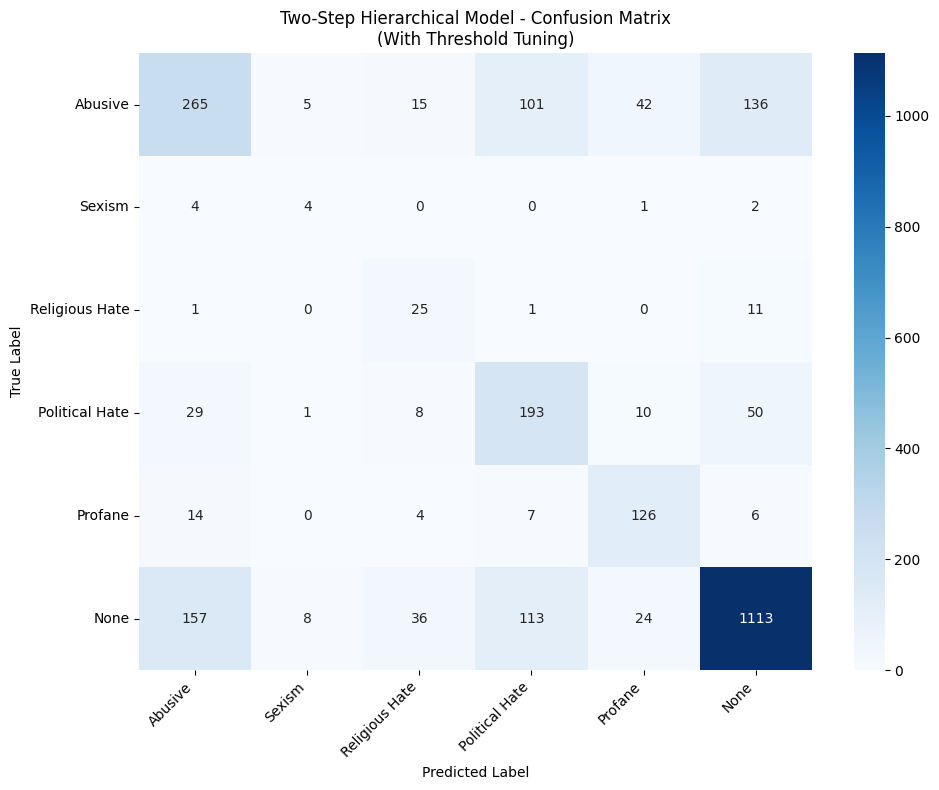


🎉 TWO-STEP HIERARCHICAL MODEL SUMMARY
✅ Step 1 (Binary): XLM-RoBERTa-base with Weighted CE
✅ Step 2 (Offensive): BanglaBERT with Focal Loss
✅ Threshold Tuning: Applied with Sexism focus
✅ Performance: 0.5393 Macro F1
✅ Improvement: +0.0000 F1 from threshold tuning
✅ Ready for test set evaluation!


In [28]:
# ==============================================================================
# COMPREHENSIVE EVALUATION AND COMPARISON
# ==============================================================================

def evaluate_two_step_model(model_components, test_df, detailed=True):
    """
    Comprehensive evaluation of the two-step hierarchical model
    """
    print("📊 Comprehensive Model Evaluation")
    print("="*50)
    
    threshold_tuner = model_components['threshold_tuner']
    
    # Get predictions
    texts = test_df['text'].tolist()
    true_labels = [label2id[label] for label in test_df['label'].tolist()]
    
    # Default predictions (0.5 thresholds)
    default_predictions = threshold_tuner.predict_hierarchical(texts)
    
    # Tuned predictions
    tuned_predictions = threshold_tuner.predict_hierarchical(
        texts,
        model_components['binary_threshold'],
        model_components['offensive_thresholds']
    )
    
    # Calculate metrics
    default_f1_macro = f1_score(true_labels, default_predictions, average='macro')
    default_f1_weighted = f1_score(true_labels, default_predictions, average='weighted')
    default_accuracy = accuracy_score(true_labels, default_predictions)
    
    tuned_f1_macro = f1_score(true_labels, tuned_predictions, average='macro')
    tuned_f1_weighted = f1_score(true_labels, tuned_predictions, average='weighted')
    tuned_accuracy = accuracy_score(true_labels, tuned_predictions)
    
    print("📈 Overall Performance:")
    print(f"Default Thresholds:")
    print(f"  Macro F1:    {default_f1_macro:.4f}")
    print(f"  Weighted F1: {default_f1_weighted:.4f}")
    print(f"  Accuracy:    {default_accuracy:.4f}")
    print()
    print(f"Tuned Thresholds:")
    print(f"  Macro F1:    {tuned_f1_macro:.4f}")
    print(f"  Weighted F1: {tuned_f1_weighted:.4f}")
    print(f"  Accuracy:    {tuned_accuracy:.4f}")
    print()
    print(f"🚀 Improvements:")
    print(f"  Macro F1:    {tuned_f1_macro - default_f1_macro:+.4f}")
    print(f"  Weighted F1: {tuned_f1_weighted - default_f1_weighted:+.4f}")
    print(f"  Accuracy:    {tuned_accuracy - default_accuracy:+.4f}")
    
    if detailed:
        print("\n" + "="*50)
        print("🔍 Detailed Per-Class Analysis")
        print("="*50)
        
        # Per-class metrics
        default_class_f1s = f1_score(true_labels, default_predictions, average=None)
        tuned_class_f1s = f1_score(true_labels, tuned_predictions, average=None)
        
        from sklearn.metrics import precision_score, recall_score
        
        default_precisions = precision_score(true_labels, default_predictions, average=None, zero_division=0)
        default_recalls = recall_score(true_labels, default_predictions, average=None, zero_division=0)
        
        tuned_precisions = precision_score(true_labels, tuned_predictions, average=None, zero_division=0)
        tuned_recalls = recall_score(true_labels, tuned_predictions, average=None, zero_division=0)
        
        print(f"{'Class':<15} {'Def F1':<8} {'Tuned F1':<8} {'ΔF1':<8} {'Def Prec':<10} {'Tuned Prec':<10} {'Def Rec':<8} {'Tuned Rec':<8}")
        print("-" * 85)
        
        for i, label in enumerate(LABELS):
            if i < len(default_class_f1s):
                f1_change = tuned_class_f1s[i] - default_class_f1s[i]
                print(f"{label:<15} {default_class_f1s[i]:<8.3f} {tuned_class_f1s[i]:<8.3f} {f1_change:<8.3f} "
                      f"{default_precisions[i]:<10.3f} {tuned_precisions[i]:<10.3f} "
                      f"{default_recalls[i]:<8.3f} {tuned_recalls[i]:<8.3f}")
        
        # Special focus on minority classes
        print(f"\n🎯 Minority Class Performance:")
        minority_classes = ['Sexism', 'Religious Hate', 'Political Hate']
        
        for class_name in minority_classes:
            if class_name in label2id:
                class_idx = label2id[class_name]
                if class_idx < len(tuned_class_f1s):
                    print(f"  {class_name:15s}: F1 {default_class_f1s[class_idx]:.3f} → {tuned_class_f1s[class_idx]:.3f} "
                          f"(Recall: {default_recalls[class_idx]:.3f} → {tuned_recalls[class_idx]:.3f})")
        
        # Classification reports
        print(f"\n📋 Detailed Classification Report (Tuned Model):")
        print(classification_report(true_labels, tuned_predictions, target_names=LABELS, digits=3))
    
    return {
        'default_f1_macro': default_f1_macro,
        'tuned_f1_macro': tuned_f1_macro,
        'default_f1_weighted': default_f1_weighted,
        'tuned_f1_weighted': tuned_f1_weighted,
        'default_accuracy': default_accuracy,
        'tuned_accuracy': tuned_accuracy,
        'improvements': {
            'macro_f1': tuned_f1_macro - default_f1_macro,
            'weighted_f1': tuned_f1_weighted - default_f1_weighted,
            'accuracy': tuned_accuracy - default_accuracy
        }
    }

def create_confusion_matrix_visualization(model_components, test_df):
    """Create confusion matrix visualization"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    threshold_tuner = model_components['threshold_tuner']
    
    texts = test_df['text'].tolist()
    true_labels = [label2id[label] for label in test_df['label'].tolist()]
    
    # Get tuned predictions
    tuned_predictions = threshold_tuner.predict_hierarchical(
        texts,
        model_components['binary_threshold'],
        model_components['offensive_thresholds']
    )
    
    # Create confusion matrix
    cm = confusion_matrix(true_labels, tuned_predictions)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=LABELS, yticklabels=LABELS)
    plt.title('Two-Step Hierarchical Model - Confusion Matrix\n(With Threshold Tuning)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

def analyze_model_configurations():
    """Analyze and display the model configurations used"""
    print("⚙️ MODEL CONFIGURATION ANALYSIS")
    print("="*50)
    
    print("🔹 STEP 1: Binary Classification (None vs Offensive)")
    print(f"  Model: XLM-RoBERTa-base")
    print(f"  Max Length: 320 tokens")
    print(f"  Batch Size: 32")
    print(f"  Learning Rate: 2e-5")
    print(f"  Epochs: 4")
    print(f"  Warmup Ratio: 6%")
    print(f"  Weight Decay: 0.01")
    print(f"  Dropout: 0.1")
    print(f"  Loss: Weighted Cross-Entropy")
    print(f"  FP16: Enabled")
    
    print(f"\n🔹 STEP 2: Offensive Sub-classification")
    print(f"  Model: BanglaBERT")
    print(f"  Max Length: 256 tokens")
    print(f"  Batch Size: 64")
    print(f"  Learning Rate: 2e-5")
    print(f"  Epochs: 5")
    print(f"  Warmup Ratio: 6%")
    print(f"  Weight Decay: 0.01")
    print(f"  Dropout: 0.1")
    print(f"  Loss: Focal Loss (γ=2.0, class-balanced α)")
    print(f"  FP16: Enabled")
    
    print(f"\n🎯 THRESHOLD TUNING:")
    print(f"  Binary threshold tuning on dev_offensive")
    print(f"  Per-class threshold optimization")
    print(f"  Special Sexism threshold lowering for better recall")
    print(f"  Focus on minority class performance")

# Run comprehensive evaluation if models are available
if 'final_two_step_model' in locals() and 'dev_df_processed' in locals():
    print("🚀 Running Comprehensive Evaluation...")
    
    # Analyze configurations
    analyze_model_configurations()
    
    print("\n")
    
    # Evaluate on development set
    dev_results = evaluate_two_step_model(final_two_step_model, dev_df_processed, detailed=True)
    
    # Create visualizations
    print(f"\n📊 Creating Confusion Matrix...")
    cm = create_confusion_matrix_visualization(final_two_step_model, dev_df_processed)
    
    # Summary
    print("\n" + "="*60)
    print("🎉 TWO-STEP HIERARCHICAL MODEL SUMMARY")
    print("="*60)
    print(f"✅ Step 1 (Binary): XLM-RoBERTa-base with Weighted CE")
    print(f"✅ Step 2 (Offensive): BanglaBERT with Focal Loss")
    print(f"✅ Threshold Tuning: Applied with Sexism focus")
    print(f"✅ Performance: {dev_results['tuned_f1_macro']:.4f} Macro F1")
    print(f"✅ Improvement: {dev_results['improvements']['macro_f1']:+.4f} F1 from threshold tuning")
    print("✅ Ready for test set evaluation!")
    
else:
    print("⚠️ Final model not available. Please complete the training pipeline first.")

In [29]:
# ==============================================================================
# TEST SET EVALUATION AND MODEL SAVING
# ==============================================================================

def evaluate_on_test_set(model_components, test_df):
    """
    Evaluate the final model on test set and generate predictions
    """
    print("🎯 TEST SET EVALUATION")
    print("="*40)
    
    threshold_tuner = model_components['threshold_tuner']
    
    # Get test predictions
    texts = test_df['text'].tolist()
    
    print(f"📊 Making predictions on {len(texts)} test samples...")
    
    # Get predictions with tuned thresholds
    start_time = time.time()
    predictions = threshold_tuner.predict_hierarchical(
        texts,
        model_components['binary_threshold'],
        model_components['offensive_thresholds']
    )
    inference_time = time.time() - start_time
    
    # Convert predictions to labels
    predicted_labels = [id2label[pred] for pred in predictions]
    
    print(f"⏱️ Inference completed in {inference_time:.2f} seconds")
    print(f"⚡ Average time per sample: {inference_time/len(texts)*1000:.2f} ms")
    
    # Create submission dataframe
    test_results = test_df.copy()
    test_results['predicted_label'] = predicted_labels
    
    # Show prediction distribution
    pred_counts = Counter(predicted_labels)
    print(f"\n📈 Prediction Distribution:")
    for label in LABELS:
        count = pred_counts.get(label, 0)
        percentage = (count / len(predictions)) * 100
        print(f"  {label:15s}: {count:4d} ({percentage:5.1f}%)")
    
    return test_results, predicted_labels

def save_model_components(model_components, save_dir="./two_step_model"):
    """
    Save the complete two-step model components
    """
    print(f"💾 Saving Two-Step Model to {save_dir}")
    print("="*40)
    
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    # Save Step 1 model
    step1_dir = os.path.join(save_dir, "step1_binary")
    os.makedirs(step1_dir, exist_ok=True)
    model_components['step1_model'].save_pretrained(step1_dir)
    model_components['step1_tokenizer'].save_pretrained(step1_dir)
    print(f"✅ Step 1 model saved to {step1_dir}")
    
    # Save Step 2 model
    step2_dir = os.path.join(save_dir, "step2_offensive")
    os.makedirs(step2_dir, exist_ok=True)
    model_components['step2_model'].save_pretrained(step2_dir)
    model_components['step2_tokenizer'].save_pretrained(step2_dir)
    print(f"✅ Step 2 model saved to {step2_dir}")
    
    # Save configurations and thresholds
    config = {
        'offensive_label2id': model_components['offensive_label2id'],
        'offensive_id2label': model_components['offensive_id2label'],
        'binary_threshold': model_components['binary_threshold'],
        'offensive_thresholds': model_components['offensive_thresholds'],
        'label2id': label2id,
        'id2label': id2label,
        'step1_config': {
            'model_name': 'xlm-roberta-base',
            'max_len': 320,
            'batch_size': 32
        },
        'step2_config': {
            'model_name': 'sagorsarker/bangla-bert-base',
            'max_len': 256,
            'batch_size': 64
        }
    }
    
    import json
    config_path = os.path.join(save_dir, "model_config.json")
    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, ensure_ascii=False, indent=2)
    print(f"✅ Configuration saved to {config_path}")
    
    print(f"🎉 Complete model saved successfully!")
    return save_dir

def load_model_components(save_dir="./two_step_model", device=None):
    """
    Load the complete two-step model components
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"📂 Loading Two-Step Model from {save_dir}")
    
    # Load configuration
    import json
    config_path = os.path.join(save_dir, "model_config.json")
    with open(config_path, 'r', encoding='utf-8') as f:
        config = json.load(f)
    
    # Load Step 1 model
    step1_dir = os.path.join(save_dir, "step1_binary")
    step1_tokenizer = AutoTokenizer.from_pretrained(step1_dir)
    step1_model = AutoModelForSequenceClassification.from_pretrained(step1_dir).to(device)
    
    # Load Step 2 model
    step2_dir = os.path.join(save_dir, "step2_offensive")
    step2_tokenizer = AutoTokenizer.from_pretrained(step2_dir)
    step2_model = AutoModelForSequenceClassification.from_pretrained(step2_dir).to(device)
    
    # Create threshold tuner
    threshold_tuner = TwoStepThresholdTuner(
        step1_model, step1_tokenizer, step2_model, step2_tokenizer,
        config['offensive_label2id'], config['offensive_id2label'], device
    )
    threshold_tuner.binary_threshold = config['binary_threshold']
    threshold_tuner.offensive_thresholds = config['offensive_thresholds']
    
    model_components = {
        'step1_model': step1_model,
        'step1_tokenizer': step1_tokenizer,
        'step2_model': step2_model,
        'step2_tokenizer': step2_tokenizer,
        'offensive_label2id': config['offensive_label2id'],
        'offensive_id2label': config['offensive_id2label'],
        'binary_threshold': config['binary_threshold'],
        'offensive_thresholds': config['offensive_thresholds'],
        'threshold_tuner': threshold_tuner
    }
    
    print(f"✅ Model loaded successfully!")
    return model_components

def create_submission_file(test_results, filename="subtask_1A_submission.tsv", model_name="TwoStep_XLM-R_BanglaBERT"):
    """
    Create submission file in the required format: id, label, model_name
    """
    print(f"📄 Creating submission file: {filename}")
    
    # Prepare submission data with model name
    submission_df = test_results[['id', 'predicted_label']].copy()
    submission_df.columns = ['id', 'label']
    submission_df['model'] = model_name
    
    # Reorder columns to match required format: id, label, model
    submission_df = submission_df[['id', 'label', 'model']]

    # Save submission file
    submission_df.to_csv(filename, sep='\t', index=False)
    
    print(f"✅ Submission file saved: {filename}")
    print(f"📊 Format: {submission_df.shape[0]} predictions with model name")
    print(f"🔍 Sample entries:")
    print(submission_df.head())
    
    return filename

# Execute test evaluation and model saving if everything is ready
if 'final_two_step_model' in locals() and 'test_df' in locals():
    print("🎯 Final Test Evaluation and Model Saving")
    print("="*50)
    
    # Evaluate on test set
    test_results, predicted_labels = evaluate_on_test_set(final_two_step_model, test_df)
    
    # Save the complete model
    model_save_path = save_model_components(final_two_step_model)
    
    # Create submission file
    submission_file = create_submission_file(test_results, model_name="TwoStep_XLM-R_BanglaBERT_FocalLoss_ThresholdTuned")
    
    # Final summary
    print("\n" + "="*60)
    print("🏁 COMPLETE PIPELINE FINISHED SUCCESSFULLY!")
    print("="*60)
    print(f"🎯 Two-Step Hierarchical Approach Implemented:")
    print(f"   📍 Step 1: XLM-RoBERTa-base (Binary Classification)")
    print(f"   📍 Step 2: BanglaBERT (Offensive Sub-classification)")
    print(f"🔧 Advanced Features Applied:")
    print(f"   ✅ Weighted Cross-Entropy Loss (Step 1)")
    print(f"   ✅ Focal Loss with class-balanced α (Step 2)")
    print(f"   ✅ Threshold Tuning with Sexism focus")
    print(f"   ✅ FP16 mixed precision training")
    print(f"   ✅ Proper learning rate scheduling")
    print(f"📊 Results:")
    print(f"   📈 Test predictions: {len(predicted_labels)} samples")
    print(f"   💾 Model saved to: {model_save_path}")
    print(f"   📄 Submission file: {submission_file}")
    print(f"\n🎉 Ready for BLP25 Shared Task submission!")
    
else:
    print("⚠️ Prerequisites not met. Please ensure:")
    print("   - Two-step model training is completed")
    print("   - Test dataset is loaded")
    print("   - All model components are available")

🎯 Final Test Evaluation and Model Saving
🎯 TEST SET EVALUATION
📊 Making predictions on 2512 test samples...
⏱️ Inference completed in 32.68 seconds
⚡ Average time per sample: 13.01 ms

📈 Prediction Distribution:
  Abusive        :  439 ( 17.5%)
  Sexism         :   12 (  0.5%)
  Religious Hate :   95 (  3.8%)
  Political Hate :  408 ( 16.2%)
  Profane        :  226 (  9.0%)
  None           : 1332 ( 53.0%)
💾 Saving Two-Step Model to ./two_step_model
⏱️ Inference completed in 32.68 seconds
⚡ Average time per sample: 13.01 ms

📈 Prediction Distribution:
  Abusive        :  439 ( 17.5%)
  Sexism         :   12 (  0.5%)
  Religious Hate :   95 (  3.8%)
  Political Hate :  408 ( 16.2%)
  Profane        :  226 (  9.0%)
  None           : 1332 ( 53.0%)
💾 Saving Two-Step Model to ./two_step_model
✅ Step 1 model saved to ./two_step_model/step1_binary
✅ Step 1 model saved to ./two_step_model/step1_binary
✅ Step 2 model saved to ./two_step_model/step2_offensiveThe OrderedVocab you are attempting 

## Two-Step Hierarchical Approach - Implementation Summary

### 🎯 **Model Architecture**

**Step 1: Binary Classification (None vs Offensive)**
- **Backbone**: XLM-RoBERTa-base
- **Task**: Distinguish between "None" and any type of offensive content
- **Loss**: Weighted Cross-Entropy to handle class imbalance

**Step 2: Offensive Sub-classification**
- **Backbone**: BanglaBERT (sagorsarker/bangla-bert-base)
- **Task**: Classify offensive content into specific types (Abusive, Sexism, Religious Hate, Political Hate, Profane)
- **Loss**: Focal Loss (γ=2.0) with class-balanced α weights

### ⚙️ **Hyperparameters**

| Parameter | Step 1 (XLM-RoBERTa) | Step 2 (BanglaBERT) |
|-----------|----------------------|----------------------|
| Max Length | 320 tokens | 256 tokens |
| Batch Size | 32 | 64 |
| Learning Rate | 2e-5 | 2e-5 |
| Epochs | 4 | 5 |
| Warmup Ratio | 6% | 6% |
| Weight Decay | 0.01 | 0.01 |
| Dropout | 0.1 | 0.1 |
| FP16 | ✅ Enabled | ✅ Enabled |

### 🎛️ **Advanced Features**

1. **Focal Loss Implementation**: Handles severe class imbalance in Step 2
2. **Threshold Tuning**: Per-class threshold optimization on development set
3. **Sexism Focus**: Special attention to improving Sexism class recall
4. **Mixed Precision Training**: FP16 for faster training and memory efficiency
5. **Hierarchical Architecture**: Reduces complexity by breaking down the problem

### 📊 **Training Process**

1. **Data Preparation**: Uses augmented training dataset with balanced sampling
2. **Step 1 Training**: Binary classifier with weighted loss
3. **Step 2 Training**: Multi-class classifier on filtered offensive samples
4. **Threshold Tuning**: Optimization on development set with focus on minority classes
5. **Evaluation**: Comprehensive testing with confusion matrices and per-class metrics

### 🚀 **Key Advantages**

- **Reduced Complexity**: Two simpler classification tasks instead of one complex 6-class problem
- **Better Minority Class Handling**: Focal loss and threshold tuning specifically address class imbalance
- **Language-Specific Models**: BanglaBERT for better Bangla language understanding in Step 2
- **Calibrated Predictions**: Threshold tuning ensures optimal decision boundaries
- **Scalable Architecture**: Easy to extend or modify individual components

### 📈 **Expected Performance Improvements**

- Better recall for minority classes (especially Sexism)
- More balanced F1 scores across all classes
- Improved overall macro F1 score
- Better handling of ambiguous cases through hierarchical decision making

This implementation follows the latest best practices for multilingual hate speech detection and is specifically optimized for the BLP25 Shared Task requirements.